## **0. Récupération du fichier de travail**

Le principe d'un moteur est de générer de l'énergie à transmettre aux roues en brûlant du carburant. Cette action génère de l'énergie mais également de multiples polluants rejetés dans l'atmosphère (dioxyde de carbone (CO2), monoxyde de carbone (CO), oxydes d'azote(NOx), hydrocarbures non brulés (HC), particules). 

Le CO2 est un polluant atmosphérique impactant le réchauffement climatique (= gaz à effet de serre).
Les autres sont des polluants nocifs pour la santé.
Ce sont tous des produits de combustion.

Les rejets de CO2 de ce dataset correspondent à une mesure du CO2 selon le cycle NEDC (Nouveau Cycle Européen de Conduite) en vigueur en 2013. Ce cycle définit les conditions dans lesquelles un véhicule est testé, allant de la vitesse à la température. 

In [4]:
import pandas as pd
import numpy as np
# Import des packages pour la visualisation des données
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_theme() # pour modifier le thème
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
import scipy.stats as stats
from scipy.stats import anderson
import statsmodels.api as sm
from statsmodels.stats.diagnostic import linear_rainbow
from scipy.stats import jarque_bera
from statsmodels.stats.api import  het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor



In [5]:
df_ori= pd.read_csv('data_2013.csv', sep = ';', encoding='unicode_escape')
# Le document ML_02_reg.csv est le DataFrame obtenu après nettoyage et analyse du DataFrame initial df_2013.csv
# C'est à partir de ces données que nous effectuerons la regression multiple

In [6]:
# On vérifie la présence de doublons:
print('Il y a ', df_ori.duplicated().sum(), 'doublons dans le dataset')

Il y a  619 doublons dans le dataset


In [7]:
# Suppression des doublons
df = df_ori.drop_duplicates(keep = 'first')
# Vérification
df.duplicated().sum(axis = 0)

0

In [8]:
# Suppression des CO2 manquants correspondant aux 'EL':
df=df.dropna(subset=['CO2 (g/km)'])

In [9]:
# Les valeurs manquantes de consommation correspondent aux consomamtions des véhicules électriques
df['Consommation urbaine (l/100km)'] = df['Consommation urbaine (l/100km)'].fillna(0)
df['Consommation extra-urbaine (l/100km)'] = df['Consommation extra-urbaine (l/100km)'].fillna(0)
df['Consommation mixte (l/100km)'] = df['Consommation mixte (l/100km)'].fillna(0)

In [10]:
df.isnull().sum()

Marque                                      0
Modèle dossier                              0
Modèle UTAC                                 0
Désignation commerciale                     0
CNIT                                        0
Type Variante Version (TVV)                 0
Carburant                                   0
Hybride                                     0
Puissance administrative                    0
Puissance maximale (kW)                     0
Boîte de vitesse                            0
Consommation urbaine (l/100km)              0
Consommation extra-urbaine (l/100km)        0
Consommation mixte (l/100km)                0
CO2 (g/km)                                  0
CO type I (g/km)                           96
HC (g/km)                               34142
NOX (g/km)                                 96
HC+NOX (g/km)                           10099
Particules (g/km)                        2631
masse vide euro min (kg)                    0
masse vide euro max (kg)          

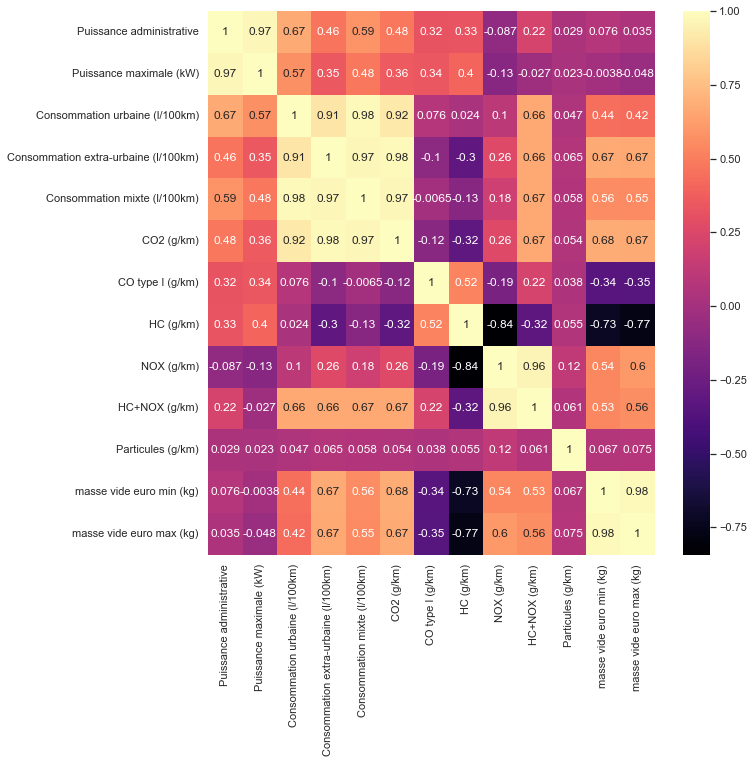

In [11]:
# Corrélation entre les variables : affichage de la heatmap
fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(df.corr(), annot = True, ax = ax, cmap = 'magma');

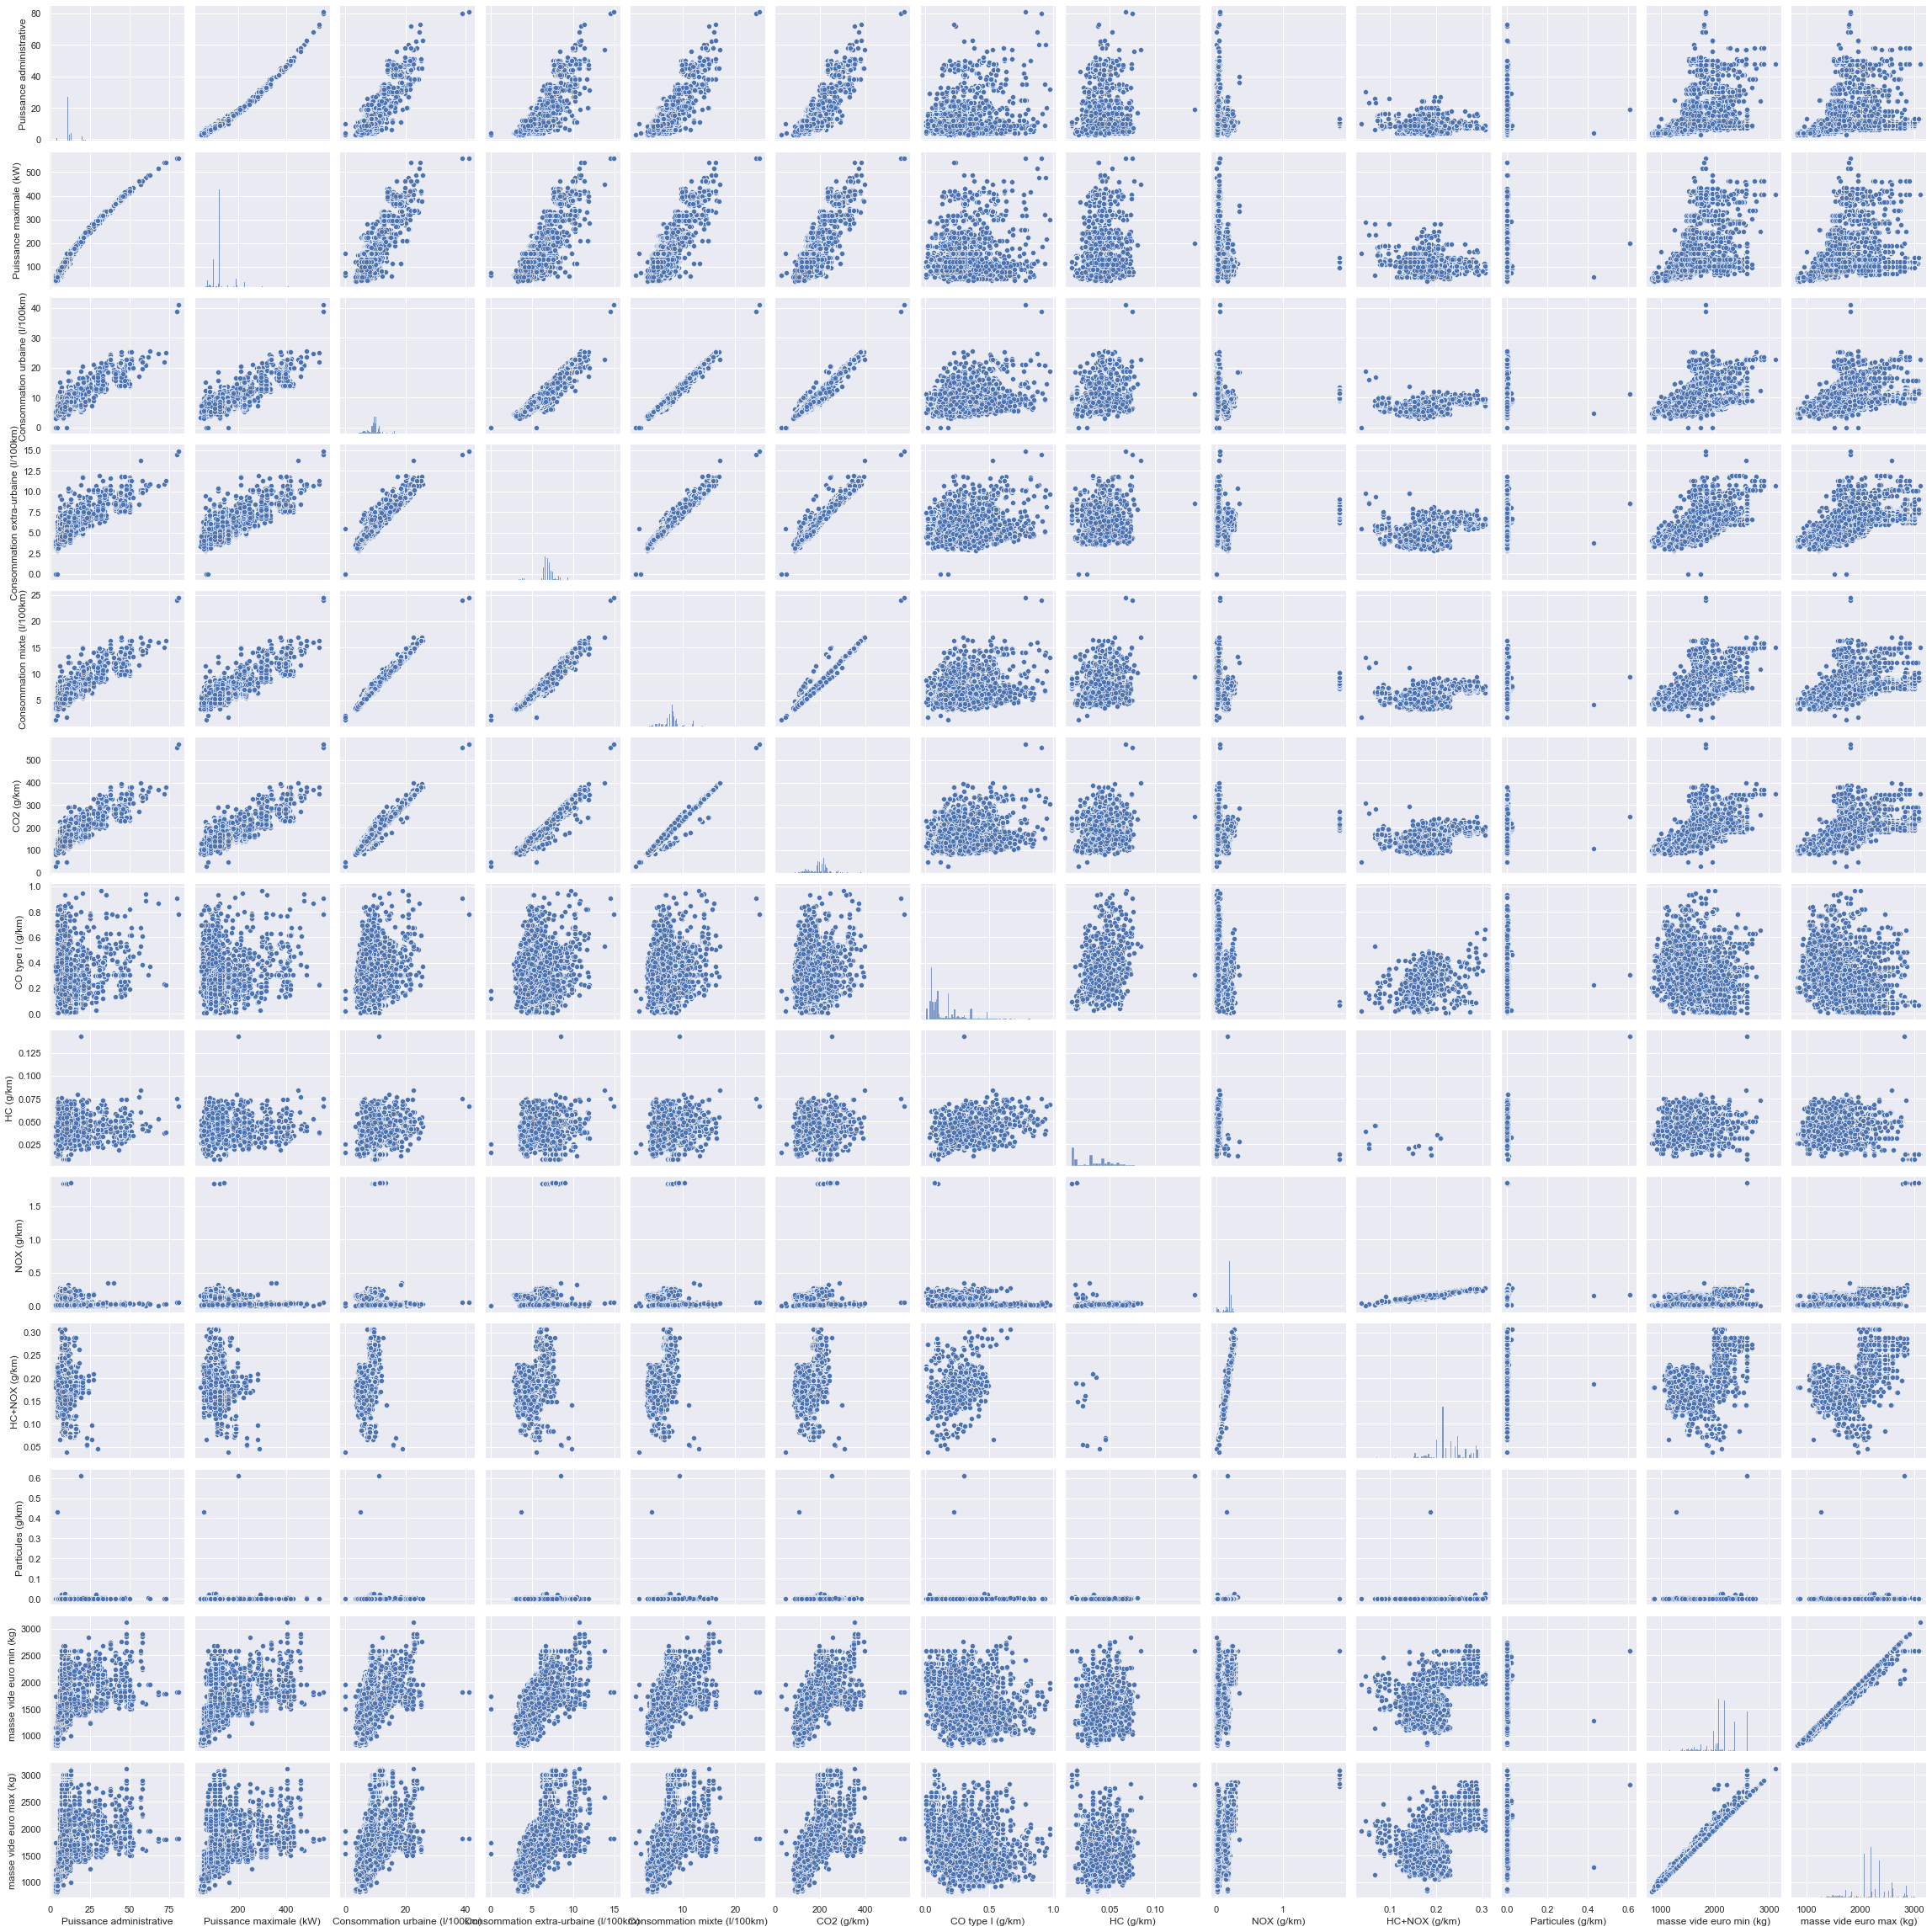

In [12]:
sns.pairplot(data = df, x_vars = df.select_dtypes(exclude = 'object').columns, y_vars = df.select_dtypes(exclude = 'object').columns)

Les variables de consommation (urbaine, extra-urbaine et mixte) ont:
    - une forte corrélation positive à la variable cible C02: le carbone du CO2 rejeté provenant du carbone du carburant, toute augmentation de la consommation entraine obligatoirement une augmentation des rejets en CO2. Les rejets de CO2 peuvent également être estimés en les calculant suivant la quantité de carburant consommée et le type de carburant. 
    - une forte corrélation postive entre elles. Elles évoluent dans le même sens.
Ces variables peuvent être supprimées.

In [13]:
# Suppression des variables inutiles (variables n'ayant pas de lien de causalité):
df = df.drop(['Puissance administrative','CNIT','NOX (g/km)','HC+NOX (g/km)','Particules (g/km)','CO type I (g/km)','HC (g/km)','Consommation urbaine (l/100km)','Consommation extra-urbaine (l/100km)','Consommation mixte (l/100km)'], axis = 1)


In [14]:
#Renomme toutes les variables (id preprocessing précédent):
df.rename(columns = {'Modèle dossier':'modele_dossier', 
                          'Modèle UTAC':'modele_UTAC',
                          'Désignation commerciale':'design_comm',
                          'Boîte de vitesse':'boite',
                          'CO2 (g/km)':'CO2'},inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44192 entries, 0 to 44849
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Marque                       44192 non-null  object 
 1   modele_dossier               44192 non-null  object 
 2   modele_UTAC                  44192 non-null  object 
 3   design_comm                  44192 non-null  object 
 4   Type Variante Version (TVV)  44192 non-null  object 
 5   Carburant                    44192 non-null  object 
 6   Hybride                      44192 non-null  object 
 7   Puissance maximale (kW)      44192 non-null  float64
 8   boite                        44192 non-null  object 
 9   CO2                          44192 non-null  float64
 10  masse vide euro min (kg)     44192 non-null  int64  
 11  masse vide euro max (kg)     44192 non-null  int64  
 12  Champ V9                     44164 non-null  object 
 13  Date de mise à j

#### ***Modifications variable boites de vitesse:***

In [15]:
df.boite.value_counts() #variable à classer en auto/manu et supprimer S6

M 6    19217
A 5    13602
A 7     8428
M 5     1191
A 6     1031
A 8      446
V 0      154
A 4       39
D 5       39
D 7       21
M 7       12
D 6       11
S 6        1
Name: boite, dtype: int64

In [16]:
# Suppression de boite S 6 et V 0 (boîtes indéfinissables):
df = df[df['boite']!='S 6']
df = df[df['boite']!='V 0']

# Vérification:
df.boite.value_counts()

M 6    19217
A 5    13602
A 7     8428
M 5     1191
A 6     1031
A 8      446
A 4       39
D 5       39
D 7       21
M 7       12
D 6       11
Name: boite, dtype: int64

In [17]:
# Regroupement des boites auto et manu:
df.boite.replace(to_replace = ['A 4', 'A 5', 'A 6', 'A 7', 'A 8', 'D 5', 'D 6', 'D 7'],
                 value = 'Auto', inplace = True)
df.boite.replace(to_replace = ['M 5', 'M 6', 'M 7'],
                 value = 'Manu', inplace = True)

In [18]:
print(pd.crosstab(df.boite, 'count'))

col_0  count
boite       
Auto   23617
Manu   20420


In [19]:
print(pd.crosstab(df.Carburant, 'count'))

col_0      count
Carburant       
EH           107
ES          6068
ES/GN         23
ES/GP         17
FE             8
GH            54
GL             1
GN            59
GN/ES         23
GO         37660
GP/ES         17


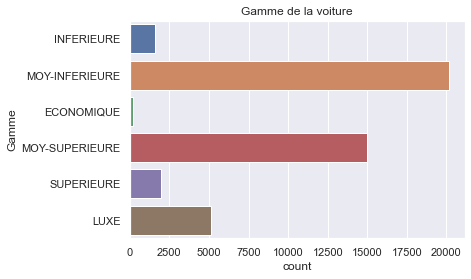

In [20]:
# Modification des labels qui ne vont pas
def change_gamme(x):
    if x in ['MOY-INFERIEURE','MOY-INFER','MOY-INF']:
        return('MOY-INFERIEURE')
    if x in ['MOY-SUPER']:
        return('MOY-SUPERIEURE')
    else : return(x)


df['gamme2']=df.gamme.apply(change_gamme)

df.gamme2.value_counts()
ordre=['INFERIEURE','MOY-INFERIEURE','ECONOMIQUE','MOY-SUPERIEURE','SUPERIEURE','LUXE']

plot_gamme=sns.countplot(y=df.gamme2,order=ordre)
plot_gamme.set(title='Gamme de la voiture')
plt.ylabel('Gamme');

In [21]:
# Vérification des doublons:
print('Il y a ', df.duplicated().sum(),'doublons')

Il y a  8636 doublons


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44037 entries, 0 to 44849
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Marque                       44037 non-null  object 
 1   modele_dossier               44037 non-null  object 
 2   modele_UTAC                  44037 non-null  object 
 3   design_comm                  44037 non-null  object 
 4   Type Variante Version (TVV)  44037 non-null  object 
 5   Carburant                    44037 non-null  object 
 6   Hybride                      44037 non-null  object 
 7   Puissance maximale (kW)      44037 non-null  float64
 8   boite                        44037 non-null  object 
 9   CO2                          44037 non-null  float64
 10  masse vide euro min (kg)     44037 non-null  int64  
 11  masse vide euro max (kg)     44037 non-null  int64  
 12  Champ V9                     44009 non-null  object 
 13  Date de mise à j

In [23]:
# Sélection des variables utiles:

df = df.drop(columns = ['modele_dossier', 'modele_UTAC', 'design_comm', "Type Variante Version (TVV)",  
                                 'masse vide euro max (kg)', 'Champ V9', 'Date de mise à jour', 'gamme'])

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44037 entries, 0 to 44849
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Marque                    44037 non-null  object 
 1   Carburant                 44037 non-null  object 
 2   Hybride                   44037 non-null  object 
 3   Puissance maximale (kW)   44037 non-null  float64
 4   boite                     44037 non-null  object 
 5   CO2                       44037 non-null  float64
 6   masse vide euro min (kg)  44037 non-null  int64  
 7   Carrosserie               44037 non-null  object 
 8   gamme2                    44037 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 4.4+ MB


In [25]:
# Vérification de la présence de doublons
print('Il y a ', df.duplicated().sum(), 'doublons')

Il y a  38908 doublons


In [26]:
# On renomme quelques variables
variables = {'gamme2' : 'gamme',
             'Puissance maximale (kW)' : 'puiss_max',
             'masse vide euro min (kg)' : 'masse_ordma_min'}

df = df.rename(variables, axis = 1)

In [27]:
# Suppression des doublons
df = df.drop_duplicates(keep = 'first')

In [28]:
# Vérification de la présence de doublons
print('Il y a ', df.duplicated().sum(), 'doublons')

Il y a  0 doublons


In [29]:
df.isnull().sum()

Marque             0
Carburant          0
Hybride            0
puiss_max          0
boite              0
CO2                0
masse_ordma_min    0
Carrosserie        0
gamme              0
dtype: int64

In [30]:
df = df.dropna(axis = 0, how = 'any')

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5129 entries, 0 to 44849
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Marque           5129 non-null   object 
 1   Carburant        5129 non-null   object 
 2   Hybride          5129 non-null   object 
 3   puiss_max        5129 non-null   float64
 4   boite            5129 non-null   object 
 5   CO2              5129 non-null   float64
 6   masse_ordma_min  5129 non-null   int64  
 7   Carrosserie      5129 non-null   object 
 8   gamme            5129 non-null   object 
dtypes: float64(2), int64(1), object(6)
memory usage: 400.7+ KB


#### ***Modifications variable boites de vitesse:***

In [32]:
# Répartition des véhicules suivant les carburants:
print(pd.crosstab(df.Carburant, 'count'))
print(df.shape)

col_0      count
Carburant       
EH            36
ES          2059
ES/GN          7
ES/GP         12
FE             5
GH            15
GL             1
GN            14
GN/ES          7
GO          2961
GP/ES         12
(5129, 9)


In [33]:
# Pourcentage de véhicules essence et diesel dans le dataset:
print('Pourcentage de véhicules essence et diesel dans le dataset =',
      round(((df.Carburant[(df['Carburant']=='ES')].count()) + (df.Carburant[(df['Carburant']=='GO')].count()))/df.Carburant.count()*100,2),
     '%')

Pourcentage de véhicules essence et diesel dans le dataset = 97.87 %


In [34]:
print('Pourcentage de véhicules non-hybride dans le dataset =',
      round(df.Carburant[(df['Hybride']=='non')].count()/df.Hybride.count()*100,2),'%')

Pourcentage de véhicules non-hybride dans le dataset = 98.99 %


In [35]:
# Les véhicules ES et GO représentent 97,87% de tous les véhicules du dataset:
# ==> on ne garde que les carburants ES et GO, les autres carburants n'étant pas suffisamment représentés:
df = df[(df['Carburant']=='ES') | (df['Carburant']=='GO')]

# Les véhicules Hybrides représentent 98,99% de tous les véhicules du dataset:
# ==> on ne garde que les véhicules non hybrides, les véhicules hybrides n'étant pas suffisamment représentés:
# Suppression de la variable hybride également:
df = df.drop('Hybride', axis = 1)

In [36]:
# Répartition ES/GO:
print(pd.crosstab(df.Carburant, 'count', normalize = True))
# Les véhicules essence représentent 40% du dataset
# Les véhicules diesel représentent 60% du dataset

col_0         count
Carburant          
ES         0.410159
GO         0.589841


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5020 entries, 0 to 44849
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Marque           5020 non-null   object 
 1   Carburant        5020 non-null   object 
 2   puiss_max        5020 non-null   float64
 3   boite            5020 non-null   object 
 4   CO2              5020 non-null   float64
 5   masse_ordma_min  5020 non-null   int64  
 6   Carrosserie      5020 non-null   object 
 7   gamme            5020 non-null   object 
dtypes: float64(2), int64(1), object(5)
memory usage: 353.0+ KB


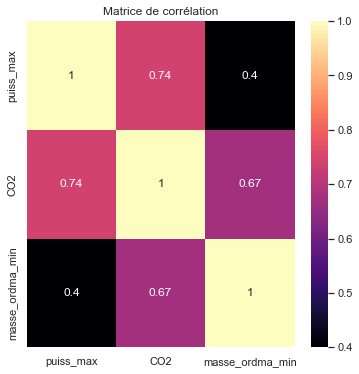

In [38]:
# Corrélation entre les variables : affichage de la heatmap
fig, ax = plt.subplots(figsize = (6, 6))
sns.heatmap(df.corr(), annot = True, ax = ax, cmap = 'magma')
plt.title('Matrice de corrélation');

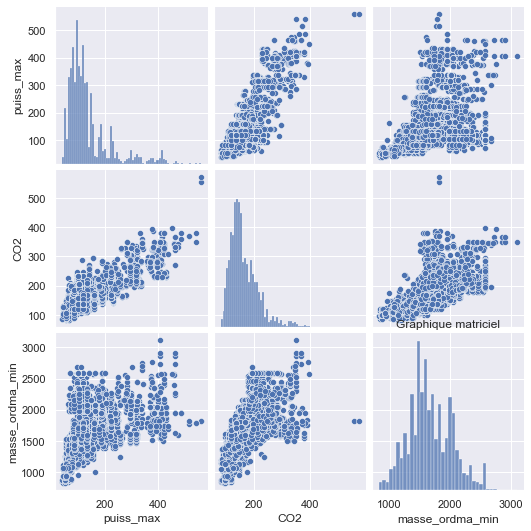

In [39]:
# Graphique matriciel:
sns.pairplot(data = df,
             x_vars = df.select_dtypes(exclude = 'object').columns,
             y_vars = df.select_dtypes(exclude = 'object').columns)
plt.title('Graphique matriciel');

### ***Création des DataFrames utiles:***

In [40]:
#Séparation de df en un dataframe numérique df_num et un dataframe catégorielle:
# Isolation variables cibles numérique (CO2):
target = df.CO2

#Séparation de df en un dataframe numérique df_num (+ suppression de la cible) et un dataframe catégorielle (+ suppression de la cible):
df_num = df.select_dtypes(exclude = 'object').drop('CO2', axis = 1)
df_cat = df.select_dtypes(include = 'object')

In [41]:
# Labélisation des variables catégorielles par labelencoder:
labelencoder = LabelEncoder()
df_cat_num=df_cat.apply(labelencoder.fit_transform)

In [42]:
# Jointure df_num avec df_cat_num en un dataframe data:
data = df_num.join(df_cat_num)
data.head()

,puiss_max,masse_ordma_min,Marque,Carburant,boite,Carrosserie,gamme
0,147.0,1505,0,0,1,1,4
1,125.0,1565,0,1,1,0,4
2,100.0,1565,0,1,1,0,4
4,125.0,1565,0,1,1,0,4
6,147.0,1555,0,0,1,1,4


In [71]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5020 entries, 0 to 44849
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   puiss_max        5020 non-null   float64
 1   masse_ordma_min  5020 non-null   int64  
 2   Marque           5020 non-null   int32  
 3   Carburant        5020 non-null   int32  
 4   boite            5020 non-null   int32  
 5   Carrosserie      5020 non-null   int32  
 6   gamme            5020 non-null   int32  
dtypes: float64(1), int32(5), int64(1)
memory usage: 344.7 KB


In [43]:
# df = ML_C02_reg.csv
# target = CO2 (g/km)

# df_num = df avec variables numériques
# df_cat = df avec variables catégorielles
# df_cat_num = df avec variables catégorielles numérisées avec LabelEncoder
# data = df_num + df_cat_num = df avec variables numériques et catégorielles numérisées avec LabelEncoder

## **III. Réalisation de la régréssion:**

### **3.1. Premier modèle:**

#### 3.1.1. Préparation du dataset  - séparation en un jeu d'entrainement et de test - standardisation des variables numériques d'entrainement:

In [44]:
# Séparation du jeu de données en un jeu d'entrainement et de test:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size = 0.2, random_state = 3)

# Sélection des variables d'origine numérique de X_train et X_test (puis_max et masse_ordma_min):
X_train_num = X_train.iloc[:,0:2]
X_test_num = X_test.iloc[:,0:2]
X_train_cat = X_train.iloc[:,2:]
X_test_cat = X_test.iloc[:,2:]

# Standardisation des données numériques (X_train_num et X_test_num):
## Ajustement du StandardScaler aux données numériques d'entrainement:
scaler = preprocessing.StandardScaler().fit(X_train_num)

## Application de la transformation à X_train_num et X_test_num:
## Transformation des arrays en dataframe en conservant les index:
X_train_num[X_train_num.columns] = pd.DataFrame(scaler.transform(X_train_num), index = X_train_num.index)
X_test_num[X_test_num.columns] = pd.DataFrame(scaler.transform(X_test_num), index = X_test_num.index)

# Jointure des X_train_num et X_test num avec X_train_cat et X_test_cat en des jeux de données standardisés X_train_std et X_test_std:
X_train_std = X_train_num.join(X_train_cat)
X_test_std = X_test_num.join(X_test_cat)

In [70]:
X_train_std.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1647 entries, 5592 to 42796
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   puiss_max        1647 non-null   float64
 1   masse_ordma_min  1647 non-null   float64
 2   Marque           1647 non-null   int32  
 3   boite            1647 non-null   int32  
 4   Carrosserie      1647 non-null   int32  
 5   gamme            1647 non-null   int32  
dtypes: float64(2), int32(4)
memory usage: 128.9 KB


#### 3.1.2. Création du modèle de régression, entraînement et évaluation du modèle:

R2 modèle_train = 0.78
R2 obtenu par CV = 0.78
R2 modèle_test = 0.76

RMSE_train = 23.95
RMSE_test = 23.53

MAE_train: 18.15
MAE_test: 18.05

Erreur relative = 11.0 %

Intercept = 173.11


,coefficient,VIF
masse_ordma_min,27.974155,1.66
Carburant,-26.112978,3.39
puiss_max,23.237605,1.61
boite,4.327626,2.41
Carrosserie,1.956510,2.17
gamme,-1.182135,3.95
Marque,0.160116,3.07


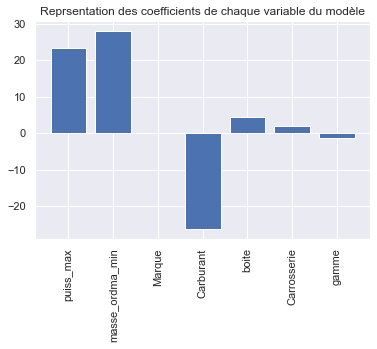

In [45]:
# Instanciation d'un modèle de régression linéaire
lr = LinearRegression()

# Entraînement et prédictions:
lr.fit(X_train_std, y_train)
pred_train = lr.predict(X_train_std) # = valeurs ajustées sfm_train
pred_test = lr.predict(X_test_std) # = valeurs ajustées sfm_test

# Affichage des metrics:
print("R2 modèle_train =", round(lr.score(X_train_std, y_train),2))
print("R2 obtenu par CV =", round(cross_val_score(lr,X_train_std,y_train, cv = 5).mean(),2))
print("R2 modèle_test =", round(lr.score(X_test_std, y_test),2))
print('\nRMSE_train =', round(np.sqrt(mean_squared_error(y_train, pred_train)),2))
print('RMSE_test =', round(np.sqrt(mean_squared_error(y_test, pred_test)),2))
print("\nMAE_train:", round(mean_absolute_error(y_train, pred_train),2))
print("MAE_test:", round(mean_absolute_error(y_test, pred_test),2))
print("\nErreur relative =", round(mean_absolute_error(y_test, pred_test) / target.mean(),2)*100, '%')

# Représentation des coefficients:
coef = lr.coef_
plt.bar(X_train_std.columns, coef)
plt.xticks(X_train_std.columns, rotation = 90)
plt.title('Reprsentation des coefficients de chaque variable du modèle')
;

# Affichage de l'intercept:
print('\nIntercept =', round(lr.intercept_,2))

# Tableau des coefficients et des VIF (Multicolinéarité)par variables:
table = pd.DataFrame({'coefficient': list(lr.coef_)}, index=list(X_train_std.columns))
# Calcul des vif et stockage dans la colonne 'VIF' de table:
table['VIF'] = [round(variance_inflation_factor(X_train_std.values, i),2) for i in range(X_train_std.shape[1])]

# Classement descendant des coefficients en valeur absolue
table.sort_values(by = 'coefficient', ascending = False, key = abs)


In [46]:
#Analyse statsmodel:
X = X_train_std
X = sm.add_constant(X) #ajout d'une constante
y = y_train
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    CO2   R-squared:                       0.780
Model:                            OLS   Adj. R-squared:                  0.779
Method:                 Least Squares   F-statistic:                     2027.
Date:                Sat, 05 Nov 2022   Prob (F-statistic):               0.00
Time:                        20:56:27   Log-Likelihood:                -18453.
No. Observations:                4016   AIC:                         3.692e+04
Df Residuals:                    4008   BIC:                         3.697e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             173.1083      1.399    1

C:\Users\gilles.ngamenye\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


#### 3.1.3. Interprétation:

Les scores obtenus sur l'échantillon d'apprentissage, par validation croisée et sur l'échantillon de test sont corrects et ne montrent pas de sur-apprentissage.

L'erreur moyenne est d'environ 11% des rejets de CO2 moyen.

Les prédictions ne sont pas optimales mais il est possible d'affiner le modèle. La variable carburant est statistiquement significative. Cette variable a beaucoup de poids dans le modèles. On observe une différence significative entre les véhicules essence et diesel.

### **3.2. Modèle affiné - Sélection de variables:**

#### 3.2.1. Création du modèle de régression et d'un sélecteur,  entraînement et évaluation du modèle:

In [47]:
# Instanciation d'un modèle de régression linéaire
lr = LinearRegression()

# Création d'un sélecteur à partir de lr:
sfm = SelectFromModel(lr)

# Entrainement du selecteur et sauvegarde des colonnes de X_train_std sélectionnées par sfm dans sfm_train:
sfm_train = pd.DataFrame(sfm.fit_transform(X_train_std, y_train), index = X_train_std.index)
sfm_train = X_train_std[X_train_std.columns[sfm.get_support()]]

# Sauvegarde des colonnes de X_test_std dans sfm_test:
sfm_test = sfm.transform(X_test_std)
sfm_test = X_test_std[X_test_std.columns[sfm.get_support()]]

# Affichage des variables sélectionnées:
X_train_std.columns[sfm.get_support()]

Index(['puiss_max', 'masse_ordma_min', 'Carburant'], dtype='object')

R2 modèle_train = 0.76
R2 obtenu par CV = 0.76
R2 modèle_test = 0.74

RMSE train = 24.856
RMSE test = 24.5596

MAE_train: 18.76
MAE_test: 18.68

Erreur relative = 11.0 %


,coefficient,VIF
masse_ordma_min,29.887549,1.33
Carburant,-26.192719,1.18
puiss_max,20.758549,1.37


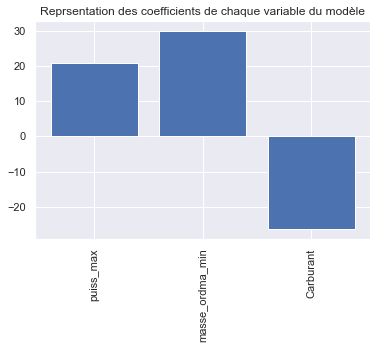

In [48]:
# Régression linéaire:
lr = LinearRegression()
lr.fit(sfm_train, y_train)
pred_train = lr.predict(sfm_train) # = valeurs ajustées sfm_train
pred_test = lr.predict(sfm_test) # = valeurs ajustées sfm_test

# Affichage des metrics:
print("R2 modèle_train =", round(lr.score(sfm_train, y_train),2))
print("R2 obtenu par CV =", round(cross_val_score(lr,sfm_train,y_train).mean(),2))
print("R2 modèle_test =", round(lr.score(sfm_test, y_test),2))
print('\nRMSE train =', round(np.sqrt(mean_squared_error(y_train, pred_train)),4))
print('RMSE test =', round(np.sqrt(mean_squared_error(y_test, pred_test)),4))
print("\nMAE_train:", round(mean_absolute_error(y_train, pred_train),2))
print("MAE_test:", round(mean_absolute_error(y_test, pred_test),2))
print("\nErreur relative =", round(mean_absolute_error(y_test, pred_test) / target.mean(),2)*100, '%')

# Représentation des coefficients:
coef = lr.coef_
plt.bar(sfm_train.columns, coef)
plt.xticks(sfm_train.columns, rotation = 90)
plt.title('Reprsentation des coefficients de chaque variable du modèle')
;

# Tableau des coefficients et des VIF (Multicolinéarité)par variables:
table = pd.DataFrame({'coefficient': list(lr.coef_)}, index=list(sfm_train.columns))
# Calcul des vif et stockage dans la colonne 'VIF' de table:
table['VIF'] = [round(variance_inflation_factor(sfm_train.values, i),2) for i in range(sfm_train.shape[1])]

# Classement descendant des coefficients en valeur absolue
table.sort_values(by = 'coefficient', ascending = False, key = abs)


C:\Users\gilles.ngamenye\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


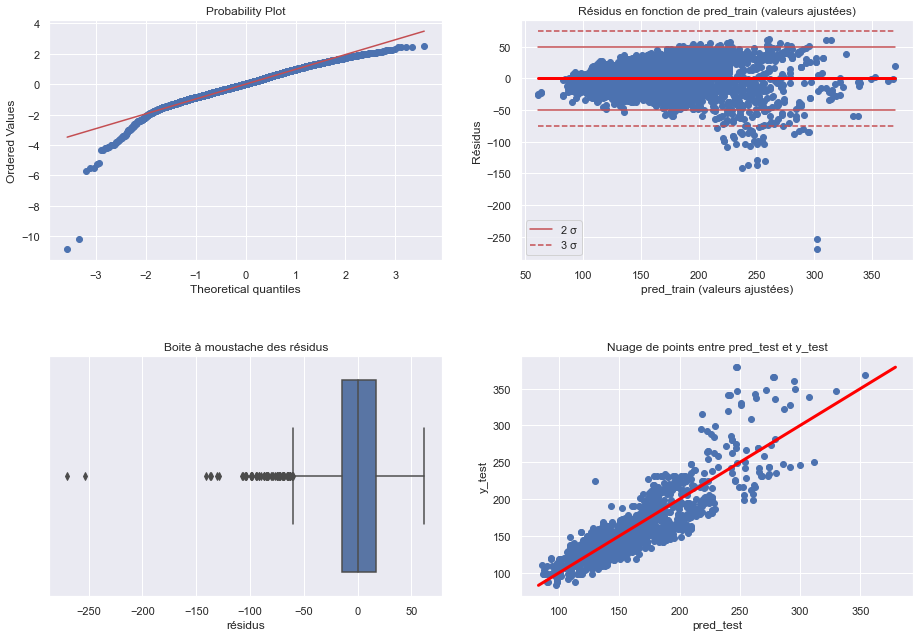

In [49]:
#Normalité des résidus:
## Calcul des résidus et résidus normalisés:
residus = pred_train - y_train 
residus_norm = (residus-residus.mean())/residus.std()
residus_std = residus/np.sqrt(sum(residus**2)/(len(residus)-1)) #utilisation des résidus standards pour test Jarque-Bera

# Graphes :
plt.figure(figsize = (15,10))
# Espacement des graphes:
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.2,
                    hspace=0.4)
## Graphe normalisation résidus:
plt.subplot(2,2,1)
stats.probplot(residus_norm, plot = plt)
## Graphe résidus en fonction de pred_train (valeurs ajustées):
plt.subplot(2,2,2)
plt.scatter(pred_train, residus)
plt.plot((pred_train.min(), pred_train.max()), (0, 0), lw=3, color='red')
plt.plot((pred_train.min(), pred_train.max()), (2*residus.std(), 2*residus.std()), 'r-', lw=1.5, label = '2 σ') 
plt.plot((pred_train.min(), pred_train.max()), (3*residus.std(), 3*residus.std()), 'r--', lw=1.5, label = '3 σ')
plt.plot((pred_train.min(), pred_train.max()), (-2*residus.std(), -2*residus.std()), 'r-',lw=1.5)
plt.plot((pred_train.min(), pred_train.max()), (-3*residus.std(), -3*residus.std()), 'r--', lw=1.5)
plt.title('Résidus en fonction de pred_train (valeurs ajustées)')
plt.xlabel('pred_train (valeurs ajustées)')
plt.ylabel('Résidus')
plt.legend()
## Graphe boxplot des résidus:
plt.subplot(2,2,3)
sns.boxplot(residus)
plt.title('Boite à moustache des résidus')
plt.xlabel('résidus')
## Graphe prédictions en fonction de y_test (= le long de la droite si elles sont bonnes):
plt.subplot(2,2,4)
plt.scatter(pred_test, y_test)
plt.title('Nuage de points entre pred_test et y_test')
plt.xlabel('pred_test')
plt.ylabel('y_test')
plt.plot((y_test.min(), y_test.max()), (y_test.min(), y_test.max()), lw = 3, color ='red');

3 variables sur 7 ont été sélectionnées:
    - puissance maximale
    - masse minimum
    - carburant (variable négative = les véhicules diesel rejettent moins de CO2 que les véhicules essence).

METRICS:
Les résultats sont presque identiques au premier modèle. On ne remarque que très peu de perte d'informations (les R2 sont bons et proches) alors que ce dernier modèle possède 2 fois moins de variables explicatives. 


Le modèle parvient à apprendre sur les données d'entraînement et à généraliser sur les données de test avec une erreur de 11% en moyenne

ANALYSE RESIDUS:

Graphe 1&2:
Les résidus ne suivent pas une loi normale. On remarque beaucoup de points extrêmes.
La présence de groupes pourrait en partie expliquer ce phénomène (1 groupe de véhicules diesel et 1 autre de véhicules essence).

Graph 3:
On observe une relation avec un leger aspect d'"entonnoir asymétrique":
    - plus y_pred augmente, plus les résidus s'éloignent de y_pred (la dispersion augmente avec y_pred),
    - à partir d'une prévision d'environ 210 g/km de CO2, la dispersion est beaucoup plus importante surtout d'un côté:  les rejets réels des véhicules sont beaucoup plus importants que prévu.
Trop de points aberrants et éloignés. 
On note que 2 véhicules rejettent nettement plus de CO2 que les autres.


#### 3.2.2. Représentation graphique et conclusion:

<IPython.core.display.Javascript object>


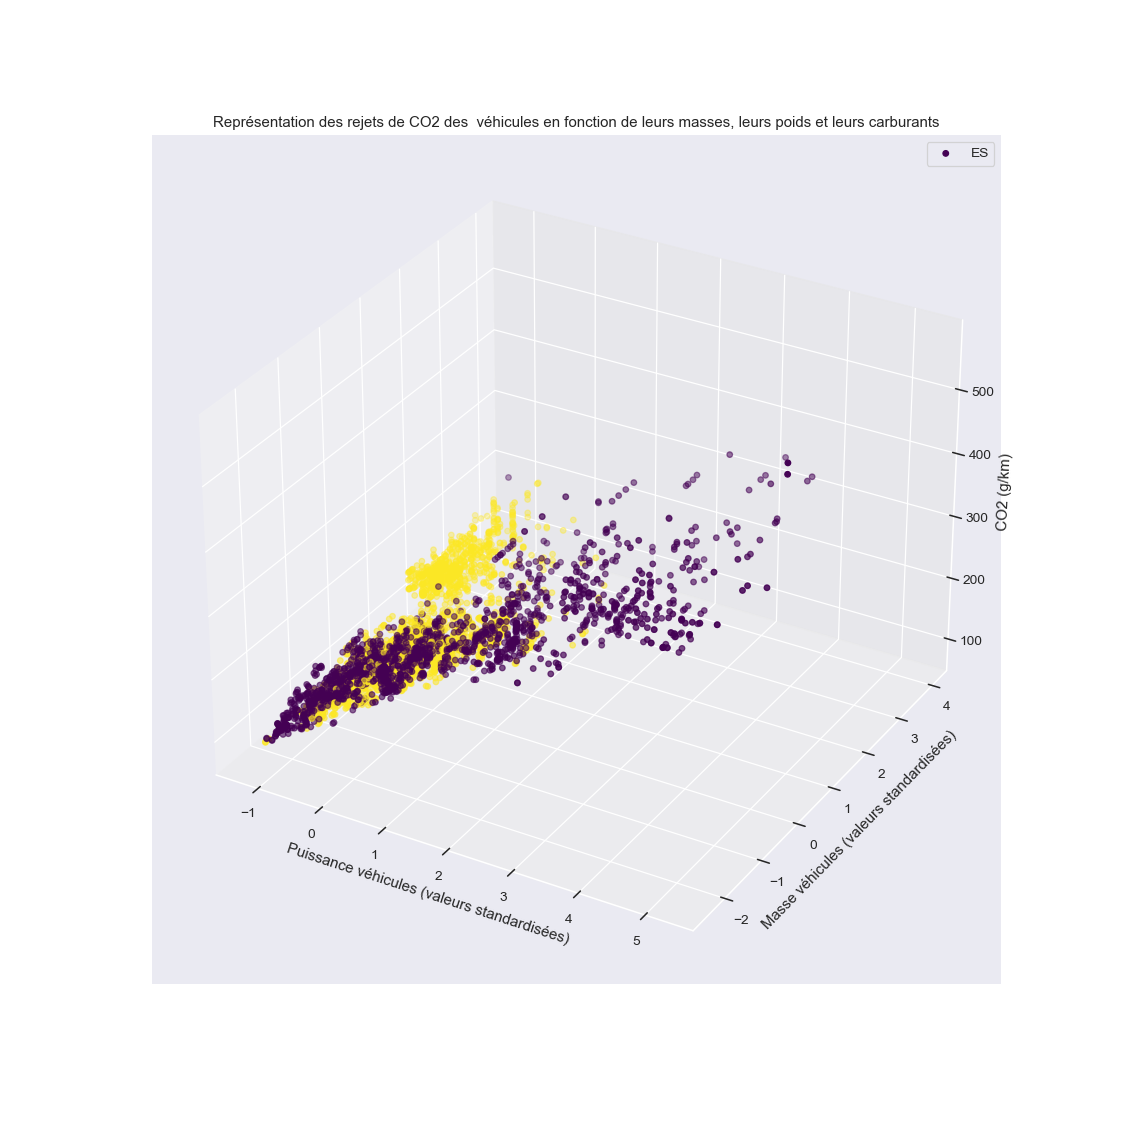

In [50]:
# Représentation graphique en 4D de l'influence de ces 3 variables significatives
#sur la variable explicative target (= rejet CO2):
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')

z = y_train
x = sfm_train['puiss_max']
y = sfm_train['masse_ordma_min']

ax.scatter(x, y, z,  c=sfm_train['Carburant'], cmap = ('viridis'))
ax.set_xlabel('Puissance véhicules (valeurs standardisées)')
ax.set_ylabel('Masse véhicules (valeurs standardisées)')
ax.set_zlabel('CO2 (g/km)')

plt.legend(['ES','GO'])
plt.title('Représentation des rejets de CO2 des  véhicules en fonction de leurs masses, leurs poids et leurs carburants')
plt.show()

La variable carburant est statistiquement significative, c'est-à-dire qu'on observe une différence significative entre les véhicules essence et diesel. Ceci semble cohérant. L'essence et le diesel ont des propriétés différentes et les moteurs associés ont des technologies différentes.

Le graphe précédent nous montre bien l'impact de la variable carburant sur les rejets de CO2. Il semble que les rejets de CO2 sont plus dépendants de la masse du véhicule pour les véhicules diesel et de la puissance maximale pour les véhicules essence.

Il pourrait donc être judicieux de créer 2 modèles différents: un essence et un diesel pour le confirmer.

### 3.3. Impact des catégories essence (ES) et diesel (GO) sur les rejets de CO2 (= target):

<IPython.core.display.Javascript object>


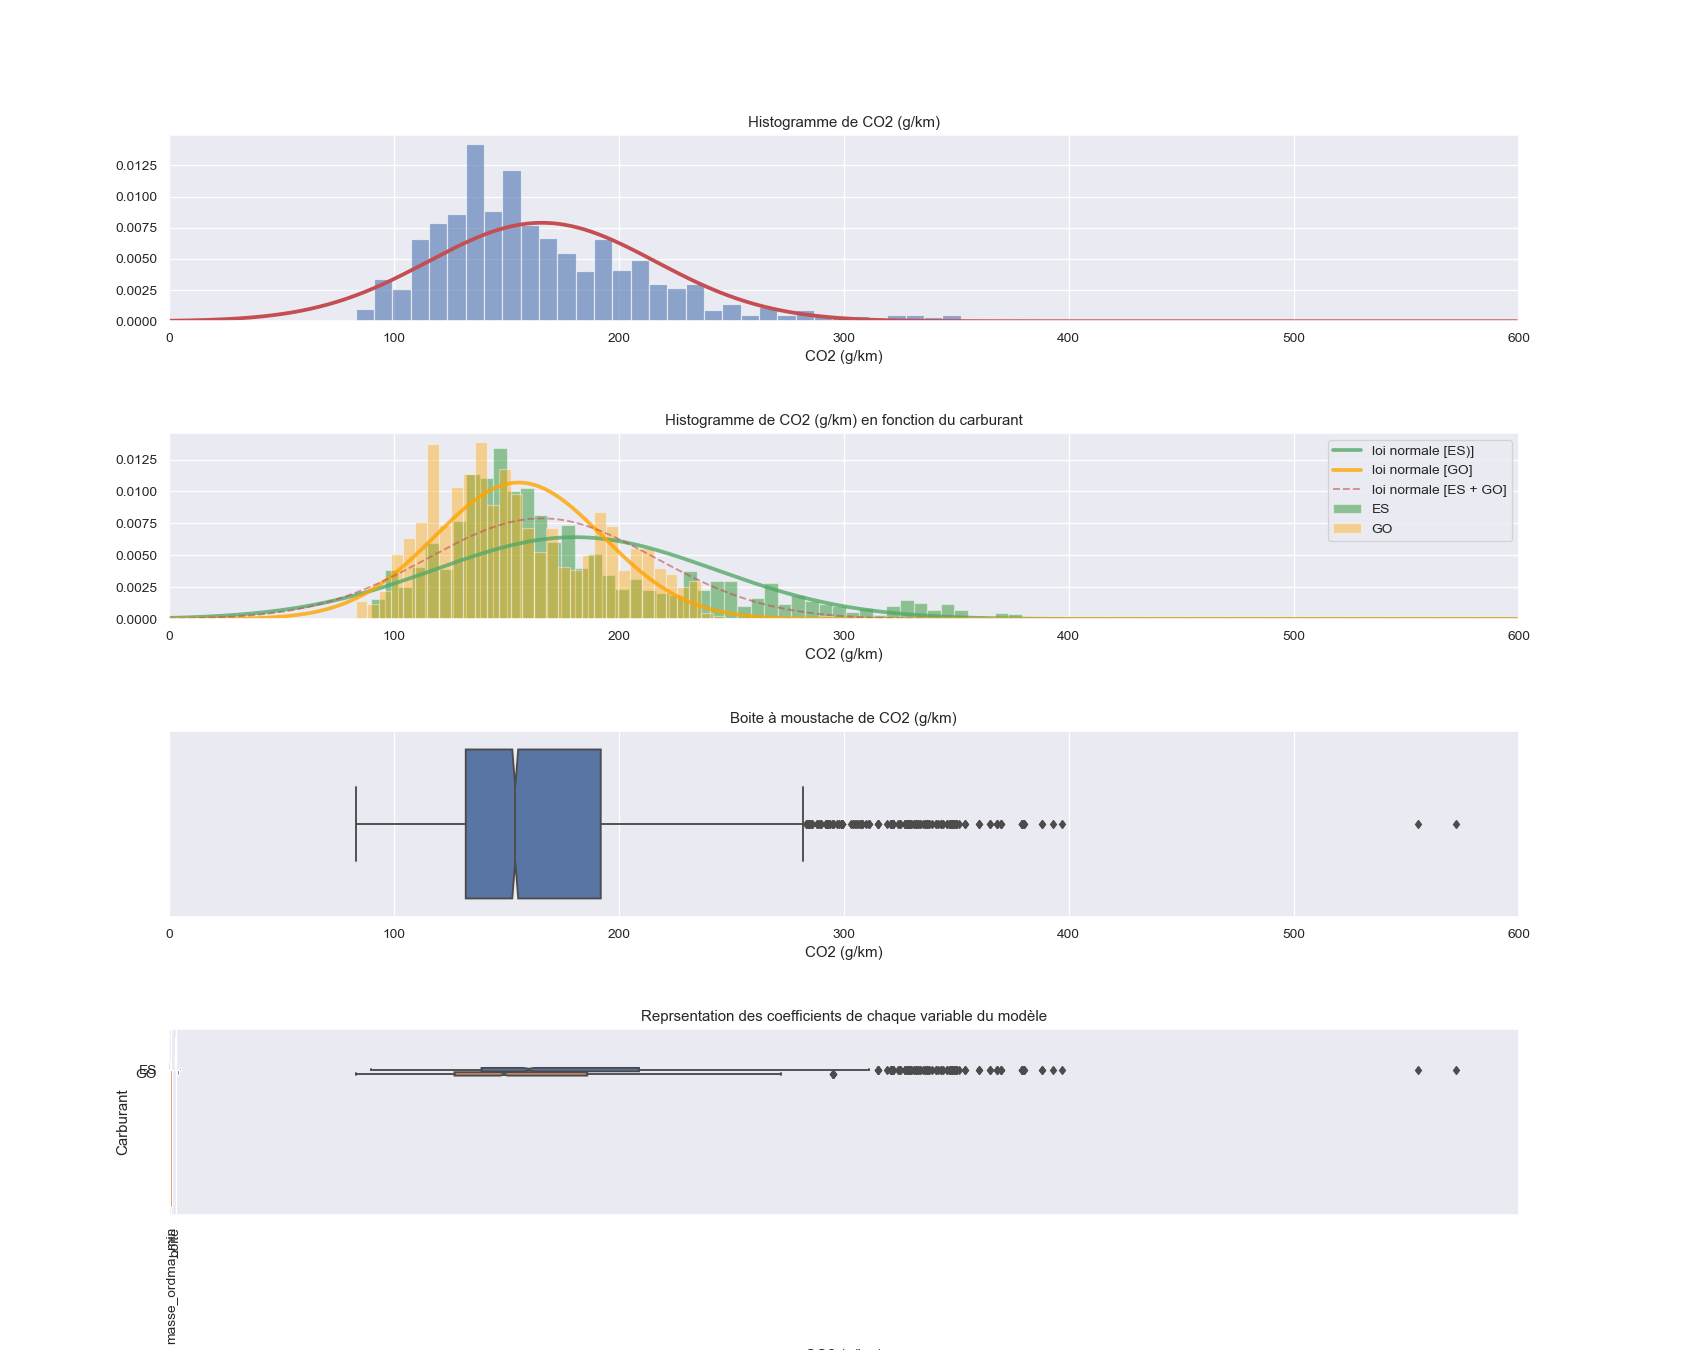

C:\Users\gilles.ngamenye\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


KstestResult(statistic=1.0, pvalue=0.0)


,CO2,CO2 ES,CO2 GO
count,5020.000000,2059.000000,2961.000000
mean,165.814940,180.530840,155.581898
std,50.539183,62.146817,37.286140
min,83.000000,90.000000,83.000000
25%,132.000000,139.000000,127.000000
50%,154.000000,160.000000,149.000000
75%,192.000000,209.000000,186.000000
max,572.000000,572.000000,295.000000


In [51]:
from scipy.stats import norm
from scipy.stats import kstest

plt.figure(figsize =(15,12))

# Espacement des graphes:
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.2,
                    hspace=0.6)

plt.subplot(411)

# Analyse de la distribution target (CO2 (g/km)):
dist = pd.DataFrame(target)

# Histogramme de distribution:
plt.hist(dist, bins=60, density=True, alpha=0.6, color='b')
plt.title('Histogramme de CO2 (g/km)')
plt.xlim(0,600)
plt.xlabel('CO2 (g/km)')

# Représentation de la loi normale avec la moyenne et l'écart-type de la distribution:
x_axis = np.arange(0,600,1)
plt.plot(x_axis, norm.pdf(x_axis, dist.mean(), dist.std()),'r', linewidth = 3)
plt.xlim(0,600)

# Histogrammes de distribution des véhicules essence et des véhicules diesel :
plt.subplot(412)
ES = df.CO2[df['Carburant']=='ES']
GO = df.CO2[df['Carburant']=='GO']

plt.hist(ES,
         bins=80,
         density=True,
         alpha=0.4,
         color='green',
         label ='ES')

plt.hist(GO,
         bins=40,
         density=True,
         alpha=0.4,
         color='orange',
         label ='GO')
plt.title('Histogramme de CO2 (g/km) en fonction du carburant')
plt.xlabel('CO2 (g/km)')
plt.legend()

# Représentation de la loi normale avec la moyenne et l'écart-type de la distribution:
x_axis = np.arange(0,600,1)
plt.plot(x_axis,
         norm.pdf(x_axis, ES.mean(), ES.std()),
         'g',
         linewidth = 3,
         alpha = 0.8,
         label ='loi normale [ES)]')
plt.xlim(0,600)

# Représentation de la loi normale avec la moyenne et l'écart-type de la distribution:
plt.plot(x_axis,
         norm.pdf(x_axis, GO.mean(), GO.std()),
         'orange',
         linewidth = 3,
         alpha = 0.8,
         label ='loi normale [GO]')
plt.xlim(0,600)

# Représentation de la loi normale avec la moyenne et l'écart-type de la distribution:
plt.plot(x_axis,
         norm.pdf(x_axis, df.CO2.mean(), df.CO2.std()),
         'r--',
         linewidth = 1.5,
         alpha=0.6,
         label ='loi normale [ES + GO]')
plt.xlim(0,600)

plt.legend()

# Boite à moustache de la distribution:
plt.subplot(413)
sns.boxplot(dist.CO2, notch=True)
plt.title('Boite à moustache de CO2 (g/km)')
plt.xlabel('CO2 (g/km)')
plt.xlim(0,600)

# Boite à moustache de la distribution en fonction du carburant:
plt.subplot(414)
sns.boxplot(data = df, y = 'Carburant' , x = 'CO2', notch=True)
plt.xticks(rotation = 'vertical')
plt.title('Boite à moustache de CO2 (g/km) en fonction du type de carburant')
plt.xlabel('CO2 (g/km)')
plt.xlim(0,600)
plt.show()
;

# Test de normalité de la distribution (Kolomgorov-Smirnov):
print(stats.kstest(dist,'norm'))
describe = pd.DataFrame(dist.describe())
describe['CO2 ES'] = df.CO2[df['Carburant']=='ES'].describe()
describe['CO2 GO'] = df.CO2[df['Carburant']=='GO'].describe()
describe

La distribution CO2 (target) n'est pas normale.
On remarque une légère asymétrie voire un aspect bimodal.

Les distributions essence et diesel sont décalées. Les véhicules diesel semblent consommer moins que les véhicules essence. Les véhicules essence ont beaucoup de points extrêmes.

### **3.3. Analyse véhicules Diesel uniquement**

#### 3.3.1. Création du dataset regroupant tous les véhicules diesel:

In [52]:
# Création du Dataset des véhicules diesel uniquement dataGO:
dataGO = data.join(target)
dataGO = dataGO[(dataGO['Carburant']==1)]

# Suppression de la variable 'Carburant':
dataGO = dataGO.drop('Carburant', axis = 1)

dataGO.describe()

,puiss_max,masse_ordma_min,Marque,boite,Carrosserie,gamme,CO2
count,2961.000000,2961.000000,2961.000000,2961.000000,2961.000000,2961.000000,2961.000000
mean,111.753597,1761.117866,25.550827,0.587977,3.557582,2.982101,155.581898
std,36.501168,338.624504,14.034376,0.492282,3.130195,1.199669,37.286140
min,40.000000,845.000000,0.000000,0.000000,0.000000,0.000000,83.000000
25%,84.000000,1505.000000,12.000000,0.000000,0.000000,2.000000,127.000000
50%,103.000000,1700.000000,29.000000,1.000000,3.000000,3.000000,149.000000
75%,125.000000,2015.000000,34.000000,1.000000,5.000000,4.000000,186.000000
max,281.000000,2680.000000,48.000000,1.000000,9.000000,5.000000,295.000000


#### 3.3.2 Préparation du dataset  - séparation en un jeu d'entrainement et de test - standardisation des variables numériques d'entrainement:

In [53]:
# Séparation de la cible du jeu de données:
targetGO = dataGO.CO2
dataGO1 = dataGO.drop('CO2', axis = 1)

In [54]:
# Séparation du jeu de données en un jeu d'entrainement et de test:
X_train, X_test, y_train, y_test = train_test_split(dataGO1, targetGO, test_size = 0.2, random_state =3)

# Sélection des variables d'origine numérique de X_train et X_test (puis_max et masse_ordma_min):
X_train_num = X_train.iloc[:,0:2]
X_test_num = X_test.iloc[:,0:2]
X_train_cat = X_train.iloc[:,2:]
X_test_cat = X_test.iloc[:,2:]

# Standardisation des données numériques (X_train_num et X_test_num):
## Ajustement du StandardScaler aux données numériques d'entrainement:
scaler = preprocessing.StandardScaler().fit(X_train_num)

## Application de la transformation à X_train_num et X_test_num:
## Transformation des arrays en dataframe en conservant les index:
X_train_num[X_train_num.columns] = pd.DataFrame(scaler.transform(X_train_num), index = X_train_num.index)
X_test_num[X_test_num.columns] = pd.DataFrame(scaler.transform(X_test_num), index = X_test_num.index)

# Jointure des X_train_num et X_test num avec X_train_cat et X_test_cat en des jeux de données standardisés X_train_std et X_test_std:
X_train_std = X_train_num.join(X_train_cat)
X_test_std = X_test_num.join(X_test_cat)

In [55]:
# Instanciation d'un modèle de régression linéaire
lr = LinearRegression()

# Entraînement et prédictions:
lr.fit(X_train_std, y_train)
pred_train = lr.predict(X_train_std) # = valeurs ajustées sfm_train
pred_test = lr.predict(X_test_std) # = valeurs ajustées sfm_test

# Affichage des metrics:
print("R2 modèle_train =", round(lr.score(X_train_std, y_train),2))
print("R2 obtenu par CV =", round(cross_val_score(lr,X_train_std,y_train, cv = 5).mean(),2))
print("R2 modèle_test =", round(lr.score(X_test_std, y_test),2))
print('\nRMSE_train =', round(np.sqrt(mean_squared_error(y_train, pred_train)),2))
print('RMSE_test =', round(np.sqrt(mean_squared_error(y_test, pred_test)),2))
print("\nMAE_train:", round(mean_absolute_error(y_train, pred_train),2))
print("MAE_test:", round(mean_absolute_error(y_test, pred_test),2))
print("\nErreur relative =", round(mean_absolute_error(y_test, pred_test) / target.mean(),2)*100, '%')

# Représentation des coefficients:
coef = lr.coef_
plt.bar(X_train_std.columns, coef)
plt.xticks(X_train_std.columns, rotation = 90)
plt.title('Reprsentation des coefficients de chaque variable du modèle')
;

# Affichage de l'intercept:
print('\nIntercept =', round(lr.intercept_,2))

# Tableau des coefficients et des VIF (Multicolinéarité)par variables:
table = pd.DataFrame({'coefficient': list(lr.coef_)}, index=list(X_train_std.columns))
# Calcul des vif et stockage dans la colonne 'VIF' de table:
table['VIF'] = [round(variance_inflation_factor(X_train_std.values, i),2) for i in range(X_train_std.shape[1])]

# Classement descendant des coefficients en valeur absolue
table.sort_values(by = 'coefficient', ascending = False, key = abs)


R2 modèle_train = 0.8
R2 obtenu par CV = 0.8
R2 modèle_test = 0.8

RMSE_train = 16.43
RMSE_test = 17.39

MAE_train: 13.34
MAE_test: 13.81

Erreur relative = 8.0 %

Intercept = 153.01


,coefficient,VIF
masse_ordma_min,31.195051,1.33
boite,-7.576701,2.67
puiss_max,-2.018150,1.41
Carrosserie,1.318730,2.43
gamme,-0.389274,4.36
Marque,0.126668,3.35


In [56]:
#Analyse statsmodel:
X = X_train_std
X = sm.add_constant(X) #ajout d'une constante
y = y_train
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    CO2   R-squared:                       0.801
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                     1588.
Date:                Sat, 05 Nov 2022   Prob (F-statistic):               0.00
Time:                        20:56:28   Log-Likelihood:                -9988.9
No. Observations:                2368   AIC:                         1.999e+04
Df Residuals:                    2361   BIC:                         2.003e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             153.0058      1.278    1

C:\Users\gilles.ngamenye\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Les scores du modèle Diesel sont meilleurs que les scores des modèles précedents (regroupant tous les véhicules). Pas de surajustement.

Les MAE sont plus faibles.

Le modèle parvient à apprendre sur les données d'entraînement et à généraliser sur les données de test avec une erreur de 8% en moyenne

Il est possible d'affiner ce modèle en diminuant le nombre de variables

#### 3.3.4 Modèle Diesel affiné - Sélection de variables:

##### 3.3.4.1. Création du modèle de régression et d'un sélecteur,  entraînement et évaluation du modèle:

In [57]:
# Instanciation d'un modèle de régression linéaire
lr = LinearRegression()

# Création d'un sélecteur à partir de lr:
sfm = SelectFromModel(lr)

# Entrainement du selecteur et sauvegarde des colonnes de X_train_std sélectionnées par sfm dans sfm_train:
sfm_train = pd.DataFrame(sfm.fit_transform(X_train_std, y_train), index = X_train_std.index)
sfm_train = X_train_std[X_train_std.columns[sfm.get_support()]]

# Sauvegarde des colonnes de X_test_std dans sfm_test:
sfm_test = sfm.transform(X_test_std)
sfm_test = X_test_std[X_test_std.columns[sfm.get_support()]]

# Affichage des variables sélectionnées:
X_train_std.columns[sfm.get_support()]

Index(['masse_ordma_min', 'boite'], dtype='object')

In [58]:
# Régression linéaire:
lr = LinearRegression()
lr.fit(sfm_train, y_train)
pred_train = lr.predict(sfm_train) # = valeurs ajustées sfm_train
pred_test = lr.predict(sfm_test) # = valeurs ajustées sfm_test

# Affichage des metrics:
print("R2 modèle_train =", round(lr.score(sfm_train, y_train),2))
print("R2 obtenu par CV =", round(cross_val_score(lr,sfm_train,y_train).mean(),2))
print("R2 modèle_test =", round(lr.score(sfm_test, y_test),2))
print('\nRMSE train =', round(np.sqrt(mean_squared_error(y_train, pred_train)),4))
print('RMSE test =', round(np.sqrt(mean_squared_error(y_test, pred_test)),4))
print("\nMAE_train:", round(mean_absolute_error(y_train, pred_train),2))
print("MAE_test:", round(mean_absolute_error(y_test, pred_test),2))
print("\nErreur relative =", round(mean_absolute_error(y_test, pred_test) / target.mean(),2)*100, '%')

# Représentation des coefficients:
coef = lr.coef_
plt.bar(sfm_train.columns, coef)
plt.xticks(sfm_train.columns, rotation = 90)
plt.title('Reprsentation des coefficients de chaque variable du modèle')
;

# Tableau des coefficients et des VIF (Multicolinéarité)par variables:
table = pd.DataFrame({'coefficient': list(lr.coef_)}, index=list(sfm_train.columns))
# Calcul des vif et stockage dans la colonne 'VIF' de table:
table['VIF'] = [round(variance_inflation_factor(sfm_train.values, i),2) for i in range(sfm_train.shape[1])]

# Classement descendant des coefficients en valeur absolue
table.sort_values(by = 'coefficient', ascending = False, key = abs)


R2 modèle_train = 0.78
R2 obtenu par CV = 0.78
R2 modèle_test = 0.78

RMSE train = 17.1926
RMSE test = 18.3145

MAE_train: 14.04
MAE_test: 14.62

Erreur relative = 9.0 %


,coefficient,VIF
masse_ordma_min,32.047496,1.02
boite,-5.113326,1.02


In [59]:
#Analyse statsmodel:
X = sfm_train
X = sm.add_constant(X) #ajout d'une constante
y = y_train
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    CO2   R-squared:                       0.783
Model:                            OLS   Adj. R-squared:                  0.782
Method:                 Least Squares   F-statistic:                     4257.
Date:                Sat, 05 Nov 2022   Prob (F-statistic):               0.00
Time:                        20:56:28   Log-Likelihood:                -10096.
No. Observations:                2368   AIC:                         2.020e+04
Df Residuals:                    2365   BIC:                         2.021e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             158.2540      0.562    2

C:\Users\gilles.ngamenye\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<IPython.core.display.Javascript object>


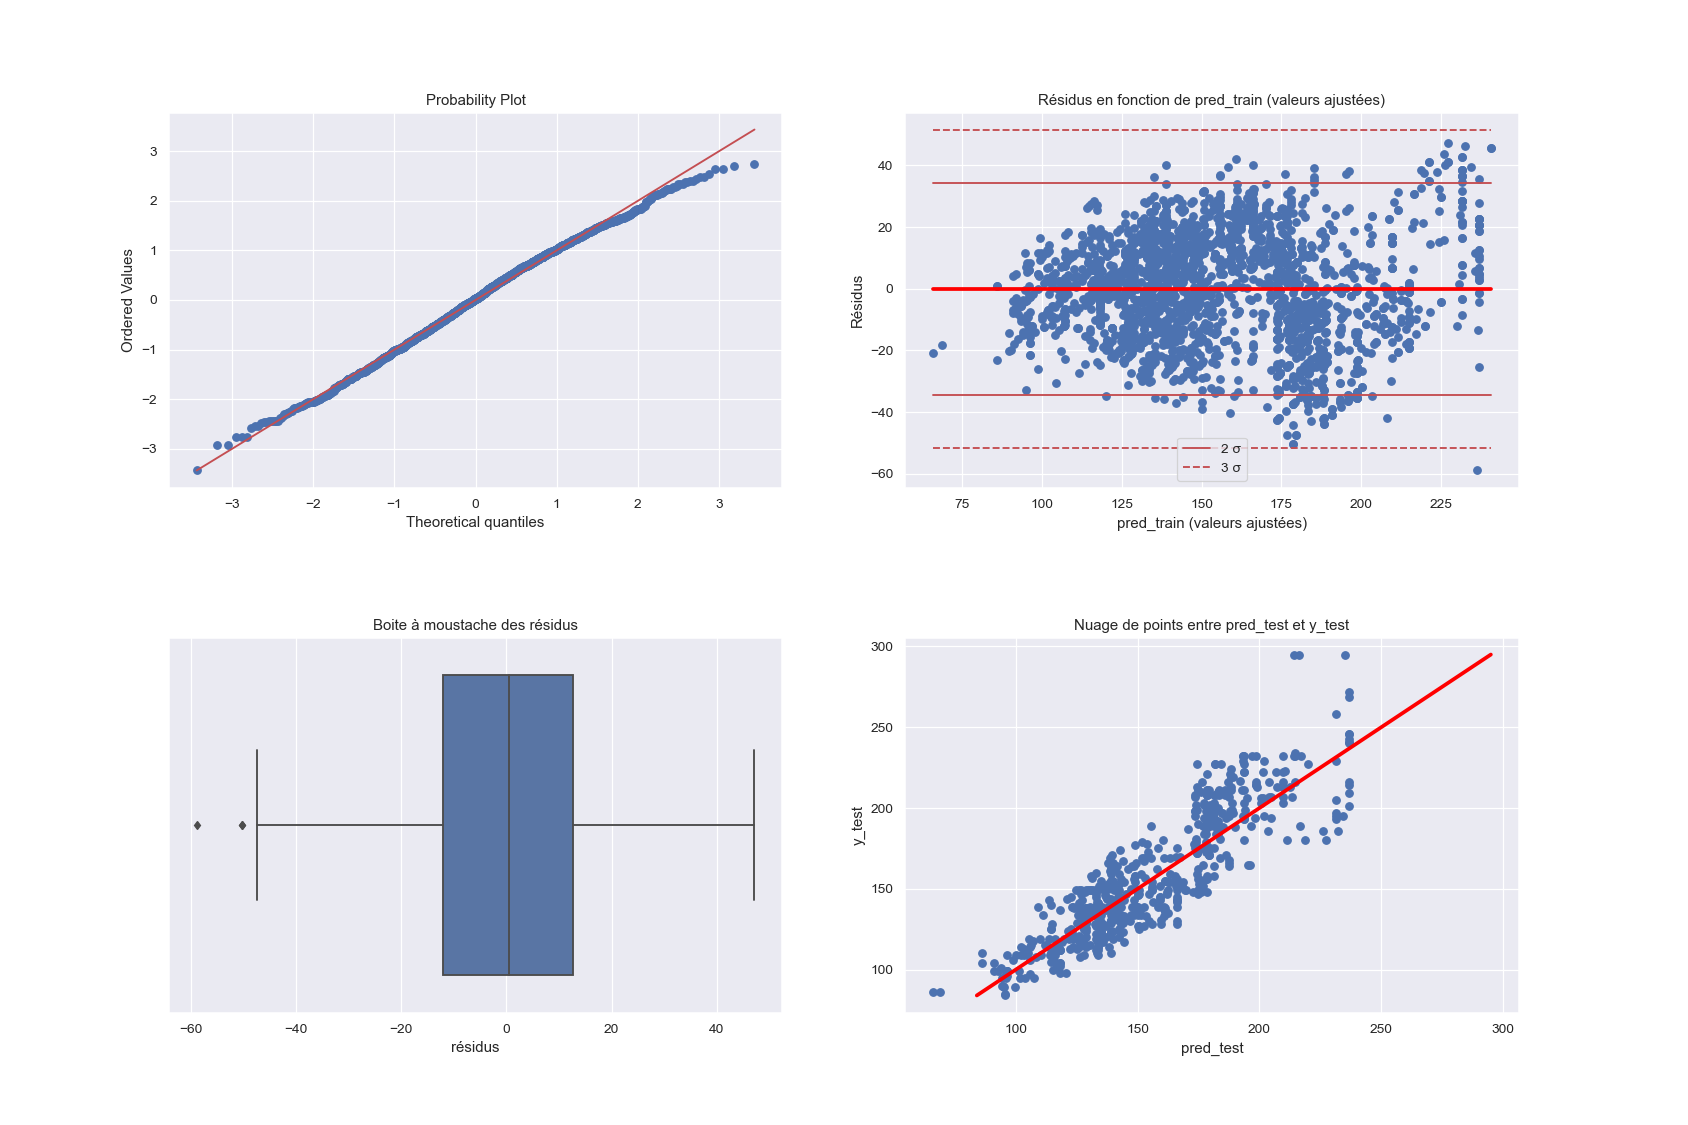

C:\Users\gilles.ngamenye\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


In [60]:
#Normalité des résidus:
## Calcul des résidus et résidus normalisés:
residus = pred_train - y_train 
residus_norm = (residus-residus.mean())/residus.std()
residus_std = residus/np.sqrt(sum(residus**2)/(len(residus)-1)) #utilisation des résidus standards pour test Jarque-Bera

# Graphes :
plt.figure(figsize = (15,10))
# Espacement des graphes:
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.2,
                    hspace=0.4)
## Graphe normalisation résidus:
plt.subplot(2,2,1)
stats.probplot(residus_norm, plot = plt)
## Graphe résidus en fonction de pred_train (valeurs ajustées):
plt.subplot(2,2,2)
plt.scatter(pred_train, residus)
plt.plot((pred_train.min(), pred_train.max()), (0, 0), lw=3, color='red')
plt.plot((pred_train.min(), pred_train.max()), (2*residus.std(), 2*residus.std()), 'r-', lw=1.5, label = '2 σ') 
plt.plot((pred_train.min(), pred_train.max()), (3*residus.std(), 3*residus.std()), 'r--', lw=1.5, label = '3 σ')
plt.plot((pred_train.min(), pred_train.max()), (-2*residus.std(), -2*residus.std()), 'r-',lw=1.5)
plt.plot((pred_train.min(), pred_train.max()), (-3*residus.std(), -3*residus.std()), 'r--', lw=1.5)
plt.title('Résidus en fonction de pred_train (valeurs ajustées)')
plt.xlabel('pred_train (valeurs ajustées)')
plt.ylabel('Résidus')
plt.legend()
## Graphe boxplot des résidus:
plt.subplot(2,2,3)
sns.boxplot(residus)
plt.title('Boite à moustache des résidus')
plt.xlabel('résidus')
## Graphe prédictions en fonction de y_test (= le long de la droite si elles sont bonnes):
plt.subplot(2,2,4)
plt.scatter(pred_test, y_test)
plt.title('Nuage de points entre pred_test et y_test')
plt.xlabel('pred_test')
plt.ylabel('y_test')
plt.plot((y_test.min(), y_test.max()), (y_test.min(), y_test.max()), lw = 3, color ='red');

L'ensemble des metrics du modèle affiné Diesel est légèrement moins bons que celui du modèle Diesel précedent, mais le nombre de variables a été divisé par 3. Pas de surajustement.

Par rapport au modèle Diesel simple, on constate, pour le modèle affiné Diesel:
    - Diminution des R2 de 2%
    - Augmentation des RMSE de moins 1 g/km
    - Augmentation des MAE de moins 0.8 g/km
    - Augmentation de l'erreur relative de 1%

Les MAE sont plus faibles.

Le modèle parvient à apprendre sur les données d'entraînement et à généraliser sur les données de test avec une erreur de 9% en moyenne

<IPython.core.display.Javascript object>


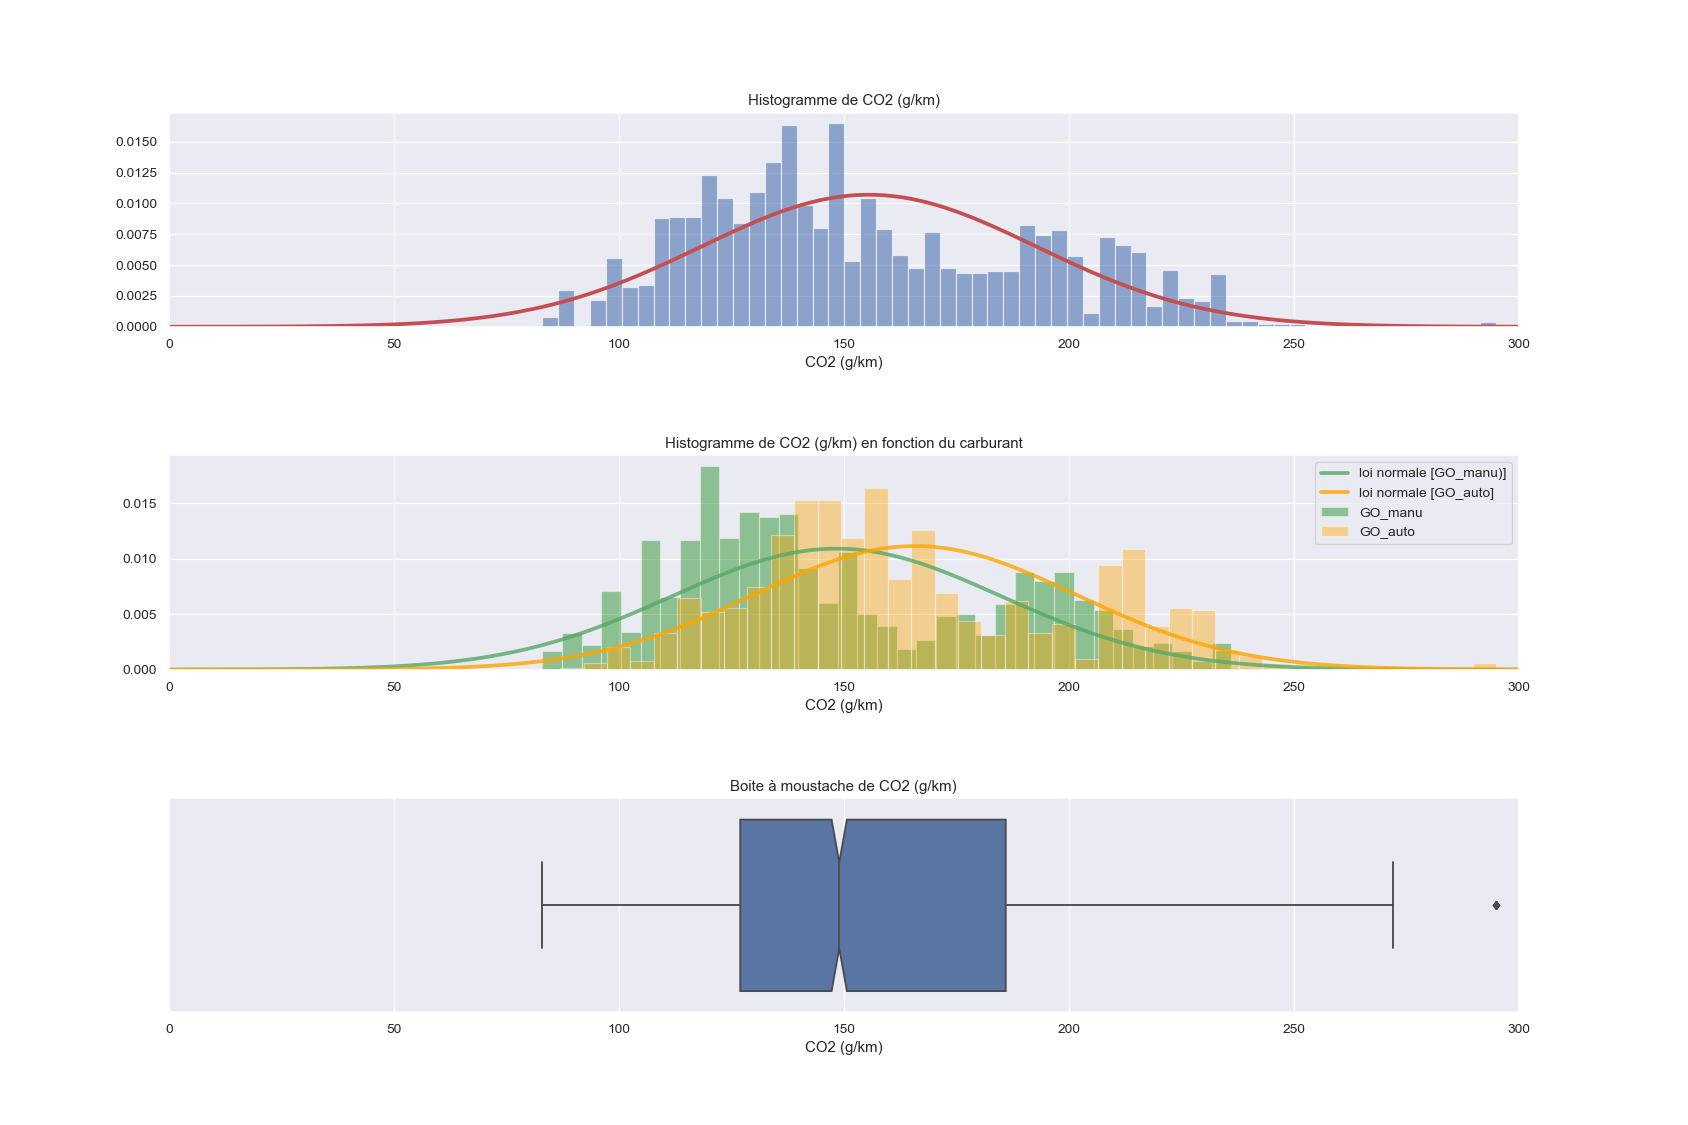

C:\Users\gilles.ngamenye\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


KstestResult(statistic=1.0, pvalue=0.0)


,CO2,GO_manu,GO_auto
count,2961.000000,1741.000000,1220.000000
mean,155.581898,148.398621,165.832787
std,37.286140,36.609035,35.832303
min,83.000000,83.000000,87.000000
25%,127.000000,119.000000,139.000000
50%,149.000000,139.000000,158.000000
75%,186.000000,183.000000,191.000000
max,295.000000,258.000000,295.000000


In [61]:
plt.figure(figsize =(15,10))

# Espacement des graphes:
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.2,
                    hspace=0.6)

plt.subplot(311)

# Analyse de la distribution des rejets des véhicules diesel (CO2 (g/km)):
dist = pd.DataFrame(df.CO2[(df['Carburant']=='GO')])

# Histogramme de distribution:
plt.hist(dist, bins=60, density=True, alpha=0.6, color='b')
plt.title('Histogramme de CO2 (g/km)')
plt.xlim(0,300)
plt.xlabel('CO2 (g/km)')

# Représentation de la loi normale avec la moyenne et l'écart-type de la distribution:
x_axis = np.arange(0,600,1)
plt.plot(x_axis, norm.pdf(x_axis, dist.mean(), dist.std()),'r', linewidth = 3)
plt.xlim(0,300)

# Histogrammes de distribution des véhicules essence et des véhicules diesel :
plt.subplot(312)
GO_manu = df.CO2[(df['Carburant']=='GO')&(df['boite']=='Manu')]
GO_auto = df.CO2[(df['Carburant']=='GO')&(df['boite']=='Auto')]

plt.hist(GO_manu,
         bins=40,
         density=True,
         alpha=0.4,
         color='green',
         label ='GO_manu')

plt.hist(GO_auto,
         bins=40,
         density=True,
         alpha=0.4,
         color='orange',
         label ='GO_auto')
plt.title('Histogramme de CO2 (g/km) en fonction du carburant')
plt.xlabel('CO2 (g/km)')
plt.legend()

# Représentation de la loi normale avec la moyenne et l'écart-type de la distribution:
x_axis = np.arange(0,600,1)
plt.plot(x_axis,
         norm.pdf(x_axis, GO_manu.mean(), GO_manu.std()),
         'g',
         linewidth = 3,
         alpha = 0.8,
         label ='loi normale [GO_manu)]')
plt.xlim(0,300)

# Représentation de la loi normale avec la moyenne et l'écart-type de la distribution:
plt.plot(x_axis,
         norm.pdf(x_axis, GO_auto.mean(), GO_auto.std()),
         'orange',
         linewidth = 3,
         alpha = 0.8,
         label ='loi normale [GO_auto]')
plt.xlim(0,300)

plt.legend()

# Boite à moustache de la distribution:
plt.subplot(313)
sns.boxplot(dist.CO2, notch=True)
plt.title('Boite à moustache de CO2 (g/km)')
plt.xlabel('CO2 (g/km)')
plt.xlim(0,300)


# Test de normalité de la distribution (Kolomgorov-Smirnov):
print(stats.kstest(dist,'norm'))
describe = pd.DataFrame(dist.describe())
describe['GO_manu'] = GO_manu.describe()
describe['GO_auto'] = GO_auto.describe()
describe

#### 3.1.3. Interprétation:

In [1]:
#CALCULS DES RESIDUS, DES RESIDUS NORMALISES et DES DISTANCES DE COOK:
## résidus:
residus = pred_train - y_train

## résidus normalisés:
residus_norm = residus/residus.std()

# distance de Cook (= identification des points trop influents):
influence = results.get_influence() # results DOIT être un model de statsmodels
(c, p) = influence.cooks_distance  # c = distance et p = p-value

NameError: name 'pred_train' is not defined

In [63]:
# AJOUT DES VARIABLES CALCULEES A DF (pred_train, résidus, résidus normalisés et distance de cook)

# 1. PRED_TRAIN:

## Création d'un DataFrame stockant pred_train en conservant les index et arrondir à une décimale:
y_pred = pd.DataFrame(pred_train, index = X_train_std.index)
y_pred.rename(columns ={0:'pred_train'}, inplace = True)
y_pred = round(y_pred.pred_train,1)

## Création df1 (= Ajout de pred_train à df):
df1 = df.join(y_pred)

## Suppression des Nans:
df1 = df1.dropna(subset=['pred_train'])


# 2. RESIDUS:

## Création d'un DataFrame stockant les résidus:
res = pd.DataFrame(residus)
res.rename(columns ={'CO2':'residus'}, inplace = True)

## Ajout des résidus à df1:
df1 = df1.join(res)


# 3. RESIDUS NORMALISES:

## Création d'un DataFrame stockant les résidus noramlisés:
res_norm = pd.DataFrame(residus_norm)
res_norm.rename(columns ={'CO2':'residus_normalisés'}, inplace = True)

## Ajout des résidus normalisés à df1:
df1 = df1.join(res_norm)

## Labelisation des résidus normalisés à 2 écarts-types:
liste = []
for residus in df1.residus_normalisés:
    if residus >2 or residus <-2:
        liste.append('res norm ±2 σ')
    else:
        liste.append('ok')
## ajout liste (=résidus normalisés labélisés à 2 EC) à df1:
df1['res_norm_±2_σ'] = liste

## Labelisation des résidus normalisés à 3 écarts-types:
liste = []
for residus in df1.residus_normalisés:
    if residus >3 or residus <-3:
        liste.append('res norm ±3 σ')
    else:
        liste.append('ok')
## ajout liste (=résidus normalisés labélisés à 3 EC) à df1:
df1['res_norm_±3_σ'] = liste

# 4.DISTANCE DE COOK:

## Création d'un DataFrame stockant les distances de Cook:
dist_cook = pd.DataFrame(c, index = res_norm.index)
dist_cook.rename(columns ={0:'dist_cook'}, inplace = True)

## Ajout des distances de Cook à df1:
df1 = df1.join(dist_cook)

## Labelisation des distances de Cook:
liste = []
for dist in df1.dist_cook:
    if dist > 4/len(y_train) or dist > 1:
        liste.append('oui')
    else:
        liste.append('non')
## ajout liste (=résidus normalisés labélisés à 3 EC) à df1:
df1['observation_influente'] = liste
df1.head()

,Marque,Carburant,puiss_max,boite,CO2,masse_ordma_min,Carrosserie,gamme,pred_train,residus,residus_normalisés,res_norm_±2_σ,res_norm_±3_σ,dist_cook,observation_influente
2,ALFA-ROMEO,GO,100.0,Manu,134.0,1565,BERLINE,MOY-SUPERIEURE,134.5,0.477732,0.027781,ok,ok,2.031320e-07,non
4,ALFA-ROMEO,GO,125.0,Manu,139.0,1565,BERLINE,MOY-SUPERIEURE,134.5,-4.522268,-0.262981,ok,ok,1.820218e-05,non
8,ALFA-ROMEO,GO,100.0,Manu,137.0,1615,BREAK,MOY-SUPERIEURE,139.2,2.231629,0.129775,ok,ok,4.176626e-06,non
18,ALFA-ROMEO,GO,120.0,Manu,142.0,1555,COUPE,MOY-SUPERIEURE,133.5,-8.473048,-0.492728,ok,ok,6.482419e-05,non
40,ALFA-ROMEO,GO,77.0,Manu,114.0,1385,BERLINE,MOY-INFERIEURE,117.4,3.363702,0.195607,ok,ok,1.420890e-05,non


In [64]:
# Validation des points aberrants à 2 et 3 écarts-types:
print('Pourcentage valeurs aberrantes à 2 ecarts-types (doit être <0.05) =',round(df1[(df1['residus_normalisés']>2)|(df1['residus_normalisés']<-2)].residus_normalisés.count()/df1.residus_normalisés.count(), 3))
print('Pourcentage valeurs aberrantes à 3 ecarts-types (doit être <0.003) =',round(df1[(df1['residus_normalisés']>3)|(df1['residus_normalisés']<-3)].residus_normalisés.count()/df1.residus_normalisés.count(), 3))

# Description des résidus élevés (+ ou - 3 EC):
df1[(df1['residus_normalisés']>3)|(df1['residus_normalisés']<-3)].describe()

Pourcentage valeurs aberrantes à 2 ecarts-types (doit être <0.05) = 0.043
Pourcentage valeurs aberrantes à 3 ecarts-types (doit être <0.003) = 0.0


,puiss_max,CO2,masse_ordma_min,pred_train,residus,residus_normalisés,dist_cook
count,1.0,1.0,1.0,1.0,1.000000,1.000000,1.000000
mean,155.0,295.0,2580.0,236.1,-58.904832,-3.425456,0.012416
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,155.0,295.0,2580.0,236.1,-58.904832,-3.425456,0.012416
25%,155.0,295.0,2580.0,236.1,-58.904832,-3.425456,0.012416
50%,155.0,295.0,2580.0,236.1,-58.904832,-3.425456,0.012416
75%,155.0,295.0,2580.0,236.1,-58.904832,-3.425456,0.012416
max,155.0,295.0,2580.0,236.1,-58.904832,-3.425456,0.012416


In [65]:
# Affichage des résidus élevés (+ ou - 3 EC):
df1[(df1['residus_normalisés']>3)|(df1['residus_normalisés']<-3)]

,Marque,Carburant,puiss_max,boite,CO2,masse_ordma_min,Carrosserie,gamme,pred_train,residus,residus_normalisés,res_norm_±2_σ,res_norm_±3_σ,dist_cook,observation_influente
8436,MERCEDES-BENZ,GO,155.0,Auto,295.0,2580,TS TERRAINS/CHEMINS,LUXE,236.1,-58.904832,-3.425456,res norm ±2 σ,res norm ±3 σ,0.012416,oui


### **X.x. Analyse véhicules Essence uniquement**

#### X. Création du dataset regroupant tous les véhicules essence:

In [66]:
# Création du Dataset des véhicules essence uniquement dataES:
dataES = data.join(target)
dataES = dataES[(dataES['Carburant']==0)]
dataES = dataES.drop('Carburant', axis = 1)
dataES.describe()

,puiss_max,masse_ordma_min,Marque,boite,Carrosserie,gamme,CO2
count,2059.000000,2059.000000,2059.000000,2059.000000,2059.000000,2059.000000,2059.000000
mean,172.492181,1552.782419,22.900923,0.465760,2.270034,2.520641,180.530840
std,107.484046,350.075380,14.529414,0.498947,2.857811,1.369860,62.146817
min,44.000000,825.000000,0.000000,0.000000,0.000000,0.000000,90.000000
25%,88.000000,1316.000000,7.000000,0.000000,0.000000,2.000000,139.000000
50%,135.000000,1525.000000,29.000000,0.000000,1.000000,2.000000,160.000000
75%,225.000000,1785.000000,33.000000,1.000000,4.000000,3.000000,209.000000
max,559.300000,3115.000000,48.000000,1.000000,9.000000,5.000000,572.000000


#### X Préparation du dataset  - séparation en un jeu d'entrainement et de test - standardisation des variables numériques d'entrainement:

In [67]:
# Séparation de la cible du jeu de données:
targetES = dataES.CO2
dataES1 = dataES.drop('CO2', axis = 1)

In [68]:
# Séparation du jeu de données en un jeu d'entrainement et de test:
X_train, X_test, y_train, y_test = train_test_split(dataES1, targetES, test_size = 0.2, random_state =2)

# Sélection des variables d'origine numérique de X_train et X_test (puis_max et masse_ordma_min):
X_train_num = X_train.iloc[:,0:2]
X_test_num = X_test.iloc[:,0:2]
X_train_cat = X_train.iloc[:,2:]
X_test_cat = X_test.iloc[:,2:]

# Standardisation des données numériques (X_train_num et X_test_num):
## Ajustement du StandardScaler aux données numériques d'entrainement:
scaler = preprocessing.StandardScaler().fit(X_train_num)

## Application de la transformation à X_train_num et X_test_num:
## Transformation des arrays en dataframe en conservant les index:
X_train_num[X_train_num.columns] = pd.DataFrame(scaler.transform(X_train_num), index = X_train_num.index)
X_test_num[X_test_num.columns] = pd.DataFrame(scaler.transform(X_test_num), index = X_test_num.index)

# Jointure des X_train_num et X_test num avec X_train_cat et X_test_cat en des jeux de données standardisés X_train_std et X_test_std:
X_train_std = X_train_num.join(X_train_cat)
X_test_std = X_test_num.join(X_test_cat)

##### X. Création du modèle de régression et d'un sélecteur,  entraînement et évaluation du modèle:

In [69]:
# Régression linéaire:
lr = LinearRegression()
lr.fit(sfm_train, y_train)
pred_train = lr.predict(sfm_train) # = valeurs ajustées sfm_train
pred_test = lr.predict(sfm_test) # = valeurs ajustées sfm_test

# Affichage des metrics:
print("R2 modèle_train =", round(lr.score(sfm_train, y_train),2))
print("R2 obtenu par CV =", round(cross_val_score(lr,sfm_train,y_train).mean(),2))
print("R2 modèle_test =", round(lr.score(sfm_test, y_test),2))
print('\nRMSE train =', round(np.sqrt(mean_squared_error(y_train, pred_train)),4))
print('RMSE test =', round(np.sqrt(mean_squared_error(y_test, pred_test)),4))
print("\nMAE_train:", round(mean_absolute_error(y_train, pred_train),2))
print("MAE_test:", round(mean_absolute_error(y_test, pred_test),2))
print("\nErreur relative =", round(mean_absolute_error(y_test, pred_test) / target.mean(),2)*100, '%')

# Représentation des coefficients:
coef = lr.coef_
plt.bar(sfm_train.columns, coef)
plt.xticks(sfm_train.columns, rotation = 90)
plt.title('Reprsentation des coefficients de chaque variable du modèle')
;

# Tableau des coefficients et des VIF (Multicolinéarité)par variables:
table = pd.DataFrame({'coefficient': list(lr.coef_)}, index=list(sfm_train.columns))
# Calcul des vif et stockage dans la colonne 'VIF' de table:
table['VIF'] = [round(variance_inflation_factor(sfm_train.values, i),2) for i in range(sfm_train.shape[1])]

# Classement descendant des coefficients en valeur absolue
table.sort_values(by = 'coefficient', ascending = False, key = abs)


ValueError: Found input variables with inconsistent numbers of samples: [2368, 1647]

In [ ]:
#Analyse statsmodel:
X = sfm_train
X = sm.add_constant(X) #ajout d'une constante
y = y_train
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

In [ ]:
#Normalité des résidus:
## Calcul des résidus et résidus normalisés:
residus = pred_train - y_train 
residus_norm = residus_norm = residus/residus.std()
residus_std = residus/np.sqrt(sum(residus**2)/(len(residus)-1)) #utilisation des résidus standards pour test Jarque-Bera

# Graphes :
plt.figure(figsize = (15,10))
# Espacement des graphes:
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.2,
                    hspace=0.4)
## Graphe normalisation résidus:
plt.subplot(2,2,1)
stats.probplot(residus_norm, plot = plt)
## Graphe résidus en fonction de pred_train (valeurs ajustées):
plt.subplot(2,2,2)
plt.scatter(pred_train, residus)
plt.plot((pred_train.min(), pred_train.max()), (0, 0), lw=3, color='red')
plt.plot((pred_train.min(), pred_train.max()), (2*residus.std(), 2*residus.std()), 'r-', lw=1.5, label = '2 σ') 
plt.plot((pred_train.min(), pred_train.max()), (3*residus.std(), 3*residus.std()), 'r--', lw=1.5, label = '3 σ')
plt.plot((pred_train.min(), pred_train.max()), (-2*residus.std(), -2*residus.std()), 'r-',lw=1.5)
plt.plot((pred_train.min(), pred_train.max()), (-3*residus.std(), -3*residus.std()), 'r--', lw=1.5)
plt.title('Résidus en fonction de pred_train (valeurs ajustées)')
plt.xlabel('pred_train (valeurs ajustées)')
plt.ylabel('Résidus')
plt.legend()
## Graphe boxplot des résidus:
plt.subplot(2,2,3)
sns.boxplot(residus)
plt.title('Boite à moustache des résidus')
plt.xlabel('résidus')
## Graphe prédictions en fonction de y_test (= le long de la droite si elles sont bonnes):
plt.subplot(2,2,4)
plt.scatter(pred_test, y_test)
plt.title('Nuage de points entre pred_test et y_test')
plt.xlabel('pred_test')
plt.ylabel('y_test')
plt.plot((y_test.min(), y_test.max()), (y_test.min(), y_test.max()), lw = 3, color ='red');

In [ ]:
#Calculs résidus, résidus normalisés, distance de cook:
## résidus:
residus = pred_train - y_train

## résidus normalisés:
residus_norm = residus/residus.std()

# distance de Cook (= identification des points trop influents):
influence = results.get_influence() # results DOIT être un model de statsmodels
(c, p) = influence.cooks_distance  # c = distance et p = p-value

In [ ]:
# AJOUT DES VARIABLES CALCULEES A DF (pred_train, résidus, résidus normalisés et distance de cook)

#PRED_TRAIN:

## Création d'un DataFrame stockant pred_train en conservant les index et arrondir à une décimale:
y_pred = pd.DataFrame(pred_train, index = sfm_train.index)
y_pred.rename(columns ={0:'pred_train'}, inplace = True)
y_pred = round(y_pred.pred_train,1)

## Création df1 (= Ajout de pred_train à df):
df1 = df.join(y_pred)

## Suppression des Nans:
df1 = df1.dropna(subset=['pred_train'])


#RESIDUS:

## Création d'un DataFrame stockant les résidus:
res = pd.DataFrame(residus)
res.rename(columns ={'CO2':'residus'}, inplace = True)

## Ajout des résidus à df1:
df1 = df1.join(res)


# RESIDUS NORMALISES:

## Création d'un DataFrame stockant les résidus noramlisés:
res_norm = pd.DataFrame(residus_norm)
res_norm.rename(columns ={'CO2':'residus_normalisés'}, inplace = True)

## Ajout des résidus normalisés à df1:
df1 = df1.join(res_norm)

## Labelisation des résidus normalisés à 2 écarts-types:
liste = []
for residus in df1.residus_normalisés:
    if residus >2 or residus <-2:
        liste.append('res norm ±2 σ')
    else:
        liste.append('ok')
## ajout liste (=résidus normalisés labélisés à 2 EC) à df1:
df1['res_norm_±2_σ'] = liste

## Labelisation des résidus normalisés à 3 écarts-types:
liste = []
for residus in df1.residus_normalisés:
    if residus >3 or residus <-3:
        liste.append('res norm ±3 σ')
    else:
        liste.append('ok')
## ajout liste (=résidus normalisés labélisés à 3 EC) à df1:
df1['res_norm_±3_σ'] = liste

# DISTANCE DE COOK:

## Création d'un DataFrame stockant les distances de Cook:
dist_cook = pd.DataFrame(c, index = res_norm.index)
dist_cook.rename(columns ={0:'dist_cook'}, inplace = True)

## Ajout des distances de Cook à df1:
df1 = df1.join(dist_cook)

## Labelisation des distances de Cook:
liste = []
for dist in df1.dist_cook:
    if dist > 4/len(y_train) or dist > 1:
        liste.append('oui')
    else:
        liste.append('non')
## ajout liste (=résidus normalisés labélisés à 3 EC) à df1:
df1['observation_influente'] = liste
df1.head()

In [ ]:
# Validation des points aberrants à 2 et 3 écarts-types:
print('Pourcentage valeurs aberrantes à 2 ecarts-types (doit être <0.05) =',round(df1[(df1['residus_normalisés']>2)|(df1['residus_normalisés']<-2)].residus_normalisés.count()/df1.residus_normalisés.count(), 3))
print('Pourcentage valeurs aberrantes à 3 ecarts-types (doit être <0.003) =',round(df1[(df1['residus_normalisés']>3)|(df1['residus_normalisés']<-3)].residus_normalisés.count()/df1.residus_normalisés.count(), 3))

# Description des résidus élevés (+ ou - 3 EC):
df1[(df1['residus_normalisés']>3)|(df1['residus_normalisés']<-3)].describe()

In [ ]:
# Affichage des résidus élevés (+ ou - 3 EC):
df1[(df1['residus_normalisés']>3)|(df1['residus_normalisés']<-3)]

In [ ]:
#Calculs résidus, résidus normalisés, distance de cook:
## résidus:
residus = pred_train - y_train

## résidus normalisés:
residus_norm = residus/residus.std()

# distance de Cook (= identification des points trop influents):
influence = results.get_influence() # results DOIT être un model de statsmodels
(c, p) = influence.cooks_distance  # c = distance et p = p-value

sns.relplot(df1.pred_train, df1.residus , hue=df1['observation_influente'])
plt.plot((pred_train.min(), pred_train.max()), (0, 0), lw=3, color='red')
plt.plot((pred_train.min(), pred_train.max()), (2*residus.std(), 2*residus.std()), 'r-', lw=1.5, label = '2 σ') 
plt.plot((pred_train.min(), pred_train.max()), (3*residus.std(), 3*residus.std()), 'r--', lw=1.5, label = '3 σ')
plt.plot((pred_train.min(), pred_train.max()), (-2*residus.std(), -2*residus.std()), 'r-',lw=1.5)
plt.plot((pred_train.min(), pred_train.max()), (-3*residus.std(), -3*residus.std()), 'r--', lw=1.5)
plt.title('Résidus en fonction de pred_train (valeurs ajustées)')
plt.xlabel('pred_train (valeurs ajustées)')
plt.ylabel('Résidus')
plt.legend();

In [ ]:
sns.relplot(df1.pred_train, df1.residus_normalisés , hue=df1['observation_influente'], col=df1['Carburant'], row=df1['gamme'])
;

In [ ]:
# Représentation graphique des résidus - de quoi sont composés ces résidus élevés?:
plt.figure(figsize = (25,8))
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0)
# Graphe Marque:
plt.subplot(1,3,1)
plt.pie(df1.Marque[(df1['residus_normalisés']>3)|(df1['residus_normalisés']<-3)].value_counts(),
        labels = df1.Marque[(df1['residus_normalisés']>3)|(df1['residus_normalisés']<-3)].value_counts().index,
       autopct = lambda x: str(round(x,2))+'%',
       shadow =True)
plt.title('Répartition des marques');

# Graphe Carburant:
plt.subplot(1,3,2)
plt.pie(df1.Carrosserie[(df1['residus_normalisés']>3)|(df1['residus_normalisés']<-3)].value_counts(),
        labels = df1.Carrosserie[(df1['residus_normalisés']>3)|(df1['residus_normalisés']<-3)].value_counts().index,
        autopct = lambda x: str(round(x,2))+'%',
       shadow =True)
plt.title('Répartition des carrosserie');

# Graphe gamme:
plt.subplot(1,3,3)
plt.pie(df1.gamme[(df1['residus_normalisés']>3)|(df1['residus_normalisés']<-3)].value_counts(),
        labels = df1.gamme[(df1['residus_normalisés']>3)|(df1['residus_normalisés']<-3)].value_counts().index,
       autopct = lambda x: str(round(x,2))+'%',
       shadow =True)
plt.title('Répartition des gammes');

Distance de Cook

In [ ]:
plt.figure(figsize = (12,7))
# Identification des points trop influents (= Distance de Cook):
## results DOIT être un model de statsmodels
influence = results.get_influence()

## c : distance et p : p-value
(c, p) = influence.cooks_distance 
plt.stem(np.arange(len(c)), c, markerfmt=':')

## 1er seuil de détection des points aberrants - ligne continue rouge
plt.axhline(y=1,color="r",linewidth=2)
## 2ème seuil de détection des points aberrants - ligne pointillée verte
plt.axhline(y=4/len(y_train),color="g",linewidth=2,linestyle="--") 

## Limite axe y (= distance de Cook)
plt.ylim(0,0.3)
plt.ylabel('Distance de Cook')
plt.xlabel('Points')
plt.title('Distance de Cook')
plt.show()

In [ ]:
# Analyse des points à forte influence:

In [ ]:
# Création d'un DataFrame stockant les distances de Cook:
dist_cook = pd.DataFrame(c, index = res_norm.index)
dist_cook.rename(columns ={0:'dist_cook'}, inplace = True)

# Ajout des distances de cook à df1:
df1 = df1.join(dist_cook)

# Labelisation des distances de Cook:
liste = []
for dist in df1.dist_cook:
    if dist >4/len(y_train):
        liste.append('dist_cook élevé')
    else:
        liste.append('ok')

# ajout des distances de cook labélisées à df1:
df1['dist_cook_lab'] = liste

In [ ]:
df1[(df1['dist_cook']>0.015)]

In [ ]:
df1[(df1['residus_normalisés']>3)|(df1['residus_normalisés']<-3)]

In [ ]:
# Focus sur les résidus à + ou - 3 EC:

In [ ]:
df1[(df1['residus_normalisés']>3)|(df1['residus_normalisés']<-3)].describe()

In [ ]:
df1[(df1['residus_normalisés']<=3)&(df1['residus_normalisés']>=-3)].describe()


In [ ]:
print(df1.Marque[(df1['residus_normalisés']>3)|(df1['residus_normalisés']<-3)].value_counts())


In [ ]:
df1.Carburant[(df1['residus_normalisés']>3)|(df1['residus_normalisés']<-3)].value_counts()

In [ ]:
df1.boite[(df1['residus_normalisés']>3)|(df1['residus_normalisés']<-3)].value_counts()

In [ ]:
df1.Carrosserie[(df1['residus_normalisés']>3)|(df1['residus_normalisés']<-3)].value_counts()

In [ ]:
df1.gamme[(df1['residus_normalisés']>3)|(df1['residus_normalisés']<-3)].value_counts()

In [ ]:
plt.figure(figsize = (12,10))
plt.subplot(2,2,1)
sns.boxplot(data = df1, x = 'res_norm_±3_σ', y = 'puiss_max')
plt.title('Comparaison des puissance max en fonction de la valeur des résidus')
plt.subplot(2,2,2)
sns.boxplot(data = df1, x = 'res_norm_±3_σ', y = 'masse_ordma_min')
plt.title('Comparaison des masses des véhicules en fonction de la valeur des résidus')
plt.subplot(2,2,3)
sns.boxplot(data = df1, x = 'Carburant', y = 'CO2', hue = 'res_norm_±3_σ' );
plt.title('Comparaison des rejets de CO2 en fonction de la valeur des résidus pour chaque carburant')
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.6, 
                    hspace=0.4);

In [ ]:
# Résidus + ou - 3 EC concernent des véhicules:
# - polluants (> 295 g/km de CO2),
# - à moteur essence (38 ES sur 39),
# - de puissance élevée (> 155 ch et moy = 382 ch),
# - type Luxe,

# FAIRE UN PIE PLOT MARQUE.... POUR MIEUX ILLUSTRER

In [ ]:
plt.figure(figsize=(8,6))
sns.boxplot(data = df1, x = 'boite', y = 'CO2', hue = 'res_norm_±3_σ' );

In [ ]:
# Controle des autres variables pour voir si on a raté qqch (trop sélectif dans les variables peut-être??)

In [ ]:
plt.figure(figsize=(16,6))
sns.boxplot(data = df1, x = 'Carrosserie', y = 'CO2', hue = 'res_norm_±3_σ' );

In [ ]:
plt.figure(figsize=(16,6))
sns.boxplot(data = df1, x = 'gamme', y = 'CO2', hue = 'res_norm_±3_σ');

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook
from matplotlib import cm

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')

z = y_train
x = sfm_train['puiss_max']
y = sfm_train['masse_ordma_min']

ax.scatter(x, y, z,  c=sfm_train['Carburant'], cmap = ('viridis'))
ax.set_xlabel('Puissance véhicules (valeurs standardisées)')
ax.set_ylabel('Masse véhicules (valeurs standardisées)')
ax.set_zlabel('CO2 (g/km)')

plt.legend(['GO','ES'])
plt.title('Représentation des rejets de CO2 des  véhicules en fonction de leurs masses, leurs poids et leurs carburants')
plt.show()

In [ ]:
sns.lmplot(data = dataGO, x = 'masse_ordma_min', y = 'CO2', hue = 'boite');

In [ ]:
plt.figure(figsize = (12,7))
# Identification des points trop influents (= Distance de Cook):
## results DOIT être un model de statsmodels
influence = results.get_influence()

## c : distance et p : p-value
(c, p) = influence.cooks_distance 
plt.stem(np.arange(len(c)), c, markerfmt=",")

## 1er seuil de détection des points aberrants - ligne continue rouge
plt.axhline(y=1,color="r",linewidth=2)
## 2ème seuil de détection des points aberrants - ligne pointillée verte
plt.axhline(y=4/len(y_train),color="g",linewidth=2,linestyle="--") 

## Limite axe y (= distance de Cook)
plt.ylim(0,0.02)
plt.ylabel('Distance de Cook')
plt.xlabel('Points')
plt.title('Distance de Cook')
plt.show()

In [ ]:
# Beaucoup de points aberrants

## **Analyse véhicules Diesel boîte manu uniquement**

In [ ]:
# Création du Dataset des véhicules diesel uniquement dataGO:
dataGOm = data.join(target)
dataGOm = dataGOm[(dataGOm['Carburant']==1)]
#dataGOm = dataGOm[(dataGOm['boite']==1)]

# Suppression de la variable Carburant:
dataGOm = dataGOm.drop('Carburant', axis = 1)
#dataGOm = dataGOm.drop('boite', axis = 1)

# Description du dataset:
dataGOm.describe()

In [ ]:
dataGOm.Carrosserie[(dataGOm['CO2']>165)].value_counts()


In [ ]:
dataGOm = dataGOm[(dataGOm.Carrosserie!=5)]
dataGOm.shape

In [ ]:
plt.figure(figsize =(10,6))

# Espacement des graphes:
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.2,
                    hspace=0.4)

plt.subplot(2,1,1)

# Analyse de la distribution CO2 des véhicules GO:
dist = pd.DataFrame(dataGOm['CO2'])

# Histogramme de distribution:
plt.hist(dist, bins=30, density=True, alpha=0.6, color='b')
plt.title('Histogramme de CO2 (g/km) - véhicules GO')
plt.xlim(0,300)
plt.xlabel('CO2 (g/km)')

# Représentation de la loi normale avec la moyenne et l'écart-type de la distribution:
x_axis = np.arange(0,300,1)
plt.plot(x_axis, norm.pdf(x_axis, dist.mean(), dist.std()),'r', linewidth = 3)
plt.xlim(0,300)

# Boite à moustache de la distribution:
plt.subplot(2,1,2)
sns.boxplot(dist.CO2)
plt.title('Boite à moustache de CO2 (g/km) - véhicules GO')
plt.xlabel('CO2 (g/km)')
plt.xlim(0,300)
plt.show();

# Test de normalité de la distribution (Kolomgorov-Smirnov):
print(stats.kstest(dist,'norm'))
dist.describe()

In [ ]:
# Séparation de la cible du jeu de données:
targetGOm = dataGOm.CO2
dataGOm1 = dataGOm.drop('CO2', axis = 1)

### **Séparation du jeu de données en des jeux d'entrainement et de test - Standardisation**

In [ ]:
# Séparation du jeu de données en un jeu d'entrainement et de test:
X_train, X_test, y_train, y_test = train_test_split(dataGOm1, targetGOm, test_size = 0.2, random_state =3)

# Sélection des variables d'origine numérique de X_train et X_test (puis_max et masse_ordma_min):
X_train_num = X_train.iloc[:,0:2]
X_test_num = X_test.iloc[:,0:2]
X_train_cat = X_train.iloc[:,2:]
X_test_cat = X_test.iloc[:,2:]

# Standardisation des données numériques (X_train_num et X_test_num):
## Ajustement du StandardScaler aux données numériques d'entrainement:
scaler = preprocessing.StandardScaler().fit(X_train_num)

## Application de la transformation à X_train_num et X_test_num:
## Transformation des arrays en dataframe en conservant les index:
X_train_num[X_train_num.columns] = pd.DataFrame(scaler.transform(X_train_num), index = X_train_num.index)
X_test_num[X_test_num.columns] = pd.DataFrame(scaler.transform(X_test_num), index = X_test_num.index)

# Jointure des X_train_num et X_test num avec X_train_cat et X_test_cat en des jeux de données standardisés X_train_std et X_test_std:
X_train_std = X_train_num.join(X_train_cat)
X_test_std = X_test_num.join(X_test_cat)

### **Régression et sélection des variables influentes**

In [ ]:
# Instanciation d'un modèle de régression linéaire
lr = LinearRegression()

# Création d'un sélecteur à partir de lr:
sfm = SelectFromModel(lr)

# Sauvegarde des colonnes de X_train_std sélectionnées par sfm dans sfm_train:
sfm_train = pd.DataFrame(sfm.fit_transform(X_train_std, y_train), index = X_train_std.index)
sfm_train = X_train_std[X_train_std.columns[sfm.get_support()]]

# Sauvegarde des colonnes de X_test_std dans sfm_test:
sfm_test = sfm.transform(X_test_std)
sfm_test = X_test_std[X_test_std.columns[sfm.get_support()]]

# Affichage des variables sélectionnées:
X_train_std.columns[sfm.get_support()]

In [ ]:
# Régression linéaire:
lr.fit(sfm_train, y_train)
pred_train = lr.predict(sfm_train) # = valeurs ajustées sfm_train
pred_test = lr.predict(sfm_test) # = valeurs ajustées sfm_test

# Affichage des metrics:
print("R2 modèle_train =", round(lr.score(sfm_train, y_train),2))
print("R2 obtenu par CV =", round(cross_val_score(lr,sfm_train,y_train).mean(),2))
print("R2 modèle_test =", round(lr.score(sfm_test, y_test),2))
print('RMSE train =', round(np.sqrt(mean_squared_error(y_train, pred_train)),2))
print('RMSE test =', round(np.sqrt(mean_squared_error(y_test, pred_test)),2))

#Analyse statsmodel:
X = sfm_train
X = sm.add_constant(X) #ajout d'une constante
y = y_train
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

# Vérifier l'indépendance des résidus (Durbin-Watson entre 1.6 et 2.4 et obj = 2)

In [ ]:
#Normalité des résidus:
## Calcul des résidus et résidus normalisés:
residus = pred_train - y_train 
residus_norm = (residus-residus.mean())/residus.std()
residus_std = residus/np.sqrt(sum(residus**2)/(len(residus)-1)) #utilisation des résidus standards pour test Jarque-Bera

# Graphes :
plt.figure(figsize = (10,7))
# Espacement des graphes:
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.2,
                    hspace=0.4)
## Graphe prédictions en fonction de y_test (= le long de la droite si elles sont bonnes):
plt.subplot(2,2,1)
plt.scatter(pred_test, y_test)
plt.title('Nuage de points entre pred_test et y_test')
plt.xlabel('pred_test')
plt.ylabel('y_test')
plt.plot((y_test.min(), y_test.max()), (y_test.min(), y_test.max()), lw = 3, color ='red')
## Graphe résidus en fonction de pred_train (valeurs ajustées):
plt.subplot(2,2,2)
plt.scatter(pred_train, residus)
plt.plot((pred_train.min(), pred_train.max()), (0, 0), lw=3, color='red')
plt.plot((pred_train.min(), pred_train.max()), (2*residus.std(), 2*residus.std()), 'r-', lw=1.5, label = '2 σ') 
plt.plot((pred_train.min(), pred_train.max()), (3*residus.std(), 3*residus.std()), 'r--', lw=1.5, label = '3 σ')
plt.plot((pred_train.min(), pred_train.max()), (-2*residus.std(), -2*residus.std()), 'r-',lw=1.5)
plt.plot((pred_train.min(), pred_train.max()), (-3*residus.std(), -3*residus.std()), 'r--', lw=1.5)
plt.title('Résidus en fonction de pred_train (valeurs ajustées)')
plt.xlabel('pred_train (valeurs ajustées)')
plt.ylabel('Résidus')
plt.legend()
## Graphe normalisation résidus:
plt.subplot(2,2,3)
stats.probplot(residus_norm, plot = plt)
## Graphe boxplot des résidus:
plt.subplot(2,2,4)
sns.boxplot(residus)
plt.title('Boite à moustache des résidus') 
plt.xlabel('résidus');

# Test normalité Jarque-Bera (doit être > 0.05)
x, pval = jarque_bera(residus_std)
print('Test de normalité (p_value jarque_bera) =', round(pval,2))

# Test égalité variance (doit être > 0.05):
lagrande, pval, f, fpval = het_breuschpagan(results.resid, results.model.exog)
print('Test égalité variance (p_value Breusch-Pagan) =', round(pval,2))

In [ ]:

print(data.duplicated().sum())

In [ ]:
## ANALYSE RESIDUS


In [ ]:
# Création d'un DataFrame stockant pour les résidus normalisés:
res_norm = pd.DataFrame(residus_norm)
res_norm.rename(columns ={'CO2':'res_norm'}, inplace = True)

# Création df2 (= Ajout des résultats des résidus normalisés à df):
df1 = df.join(res_norm)

# Suppression des Nans:
df1 = df1.dropna(subset=['res_norm'])

# Labelisation résidus normalisés:
liste = []
for residus in df1.res_norm:
    if residus >3 or residus <-3:
        liste.append('res norm >3 et <-3')
    else:
        liste.append('-3 < res norm < 3')

# ajout liste à df2:
df1['res_norm_lab'] = liste

# Validation des points aberrants à 2 et 3 écarts-types:
print('Pourcentage valeurs aberrantes à 95% (doit être <0.05) =',round(df1[(df1['res_norm']>2)|(df1['res_norm']<-2)].res_norm.count()/df1.res_norm.count(), 3))
print('Pourcentage valeurs aberrantes à 99% (doit être <0.001) =',round(df1[(df1['res_norm']>3)|(df1['res_norm']<-3)].res_norm.count()/df1.res_norm.count(), 3))

df1[(df1['res_norm']>3)|(df1['res_norm']<-3)].describe()

In [ ]:
# Résidus normaux

In [ ]:
plt.figure(figsize = (12,7))
# Identification des points trop influents (= Distance de Cook):
## results DOIT être un model de statsmodels
influence = results.get_influence()

## c : distance et p : p-value
(c, p) = influence.cooks_distance 
plt.stem(np.arange(len(c)), c, markerfmt=",")

## 1er seuil de détection des points aberrants - ligne continue rouge
plt.axhline(y=1,color="r",linewidth=2)
## 2ème seuil de détection des points aberrants - ligne pointillée verte
plt.axhline(y=4/len(y_train),color="g",linewidth=2,linestyle="--") 

## Limite axe y (= distance de Cook)
plt.ylim(0,0.1)
plt.ylabel('Distance de Cook')
plt.xlabel('Points')
plt.title('Distance de Cook')
plt.show()

In [ ]:
plt.figure(figsize = (8,6))
# Identification des points trop influents (= Distance de Cook):
## results DOIT être un model de statsmodels
influence = results.get_influence()

## c : distance et p : p-value
(c, p) = influence.cooks_distance 
plt.stem(sfm_train.index, c, markerfmt=",")

## 1er seuil de détection des points aberrants - ligne continue rouge
plt.axhline(y=1,color="r",linewidth=2)
## 2ème seuil de détection des points aberrants - ligne pointillée verte
plt.axhline(y=4/len(y_train),color="g",linewidth=2,linestyle="--") 

## Limite axe y (= distance de Cook)
plt.ylim(0,0.03)
plt.ylabel('Distance de Cook')
plt.xlabel('Points')
plt.title('Distance de Cook')
plt.show()

In [ ]:
#Calculs:
## résidus:
residus = pred_train - y_train

## résidus normalisés:
residus_norm = residus/residus.std()

# distance de Cook (= identification des points trop influents):
influence = results.get_influence() # results DOIT être un model de statsmodels
(c, p) = influence.cooks_distance  # c = distance et p = p-value

In [ ]:
# AJOUT DES VARIABLES CALCULEES A DF (pred_train, résidus, résidus normalisés et distance de cook)

#PRED_TRAIN:

## Création d'un DataFrame stockant pred_train en conservant les index et arrondir à une décimale:
y_pred = pd.DataFrame(pred_train, index = sfm_train.index)
y_pred.rename(columns ={0:'pred_train'}, inplace = True)
y_pred = round(y_pred.pred_train,1)

## Création df1 (= Ajout de pred_train à df):
df1 = df.join(y_pred)

## Suppression des Nans:
df1 = df1.dropna(subset=['pred_train'])


#RESIDUS:

## Création d'un DataFrame stockant les résidus:
res = pd.DataFrame(residus)
res.rename(columns ={'CO2':'residus'}, inplace = True)

## Ajout des résidus à df1:
df1 = df1.join(res)


# RESIDUS NORMALISES:

## Création d'un DataFrame stockant les résidus noramlisés:
res_norm = pd.DataFrame(residus_norm)
res_norm.rename(columns ={'CO2':'residus_normalisés'}, inplace = True)

## Ajout des résidus normalisés à df1:
df1 = df1.join(res_norm)

## Labelisation des résidus normalisés à 2 écarts-types:
liste = []
for residus in df1.residus_normalisés:
    if residus >2 or residus <-2:
        liste.append('res norm ±2 σ')
    else:
        liste.append('ok')
## ajout liste (=résidus normalisés labélisés à 2 EC) à df1:
df1['res_norm_±2_σ'] = liste

## Labelisation des résidus normalisés à 3 écarts-types:
liste = []
for residus in df1.residus_normalisés:
    if residus >3 or residus <-3:
        liste.append('res norm ±3 σ')
    else:
        liste.append('ok')
## ajout liste (=résidus normalisés labélisés à 3 EC) à df1:
df1['res_norm_±3_σ'] = liste

# DISTANCE DE COOK:

## Création d'un DataFrame stockant les distances de Cook:
dist_cook = pd.DataFrame(c, index = res_norm.index)
dist_cook.rename(columns ={0:'dist_cook'}, inplace = True)

## Ajout des distances de Cook à df1:
df1 = df1.join(dist_cook)

## Labelisation des distances de Cook:
liste = []
for dist in df1.dist_cook:
    if dist > 4/len(y_train) or dist > 1:
        liste.append('oui')
    else:
        liste.append('non')
## ajout liste (=résidus normalisés labélisés à 3 EC) à df1:
df1['observation_influente'] = liste
df1.head()

In [ ]:
df1[(df1['dist_cook']>0.04)]

In [ ]:
dataGOm = dataGOm.drop([2576,42000,43776], axis = 0)

## **Analyse véhicules Diesel boîte auto uniquement**

In [ ]:
# Création du Dataset des véhicules diesel boite auto uniquement dataGO:
dataGOa = data.join(target)
dataGOa = dataGOa[(dataGOa['Carburant']==1)]
dataGOa = dataGOa[(dataGOa['boite']==0)]

# Suppression de la variable Carburant:
dataGOa = dataGOa.drop('Carburant', axis = 1)
dataGOa = dataGOa.drop('boite', axis = 1)

# Description du dataset:
dataGOa.describe()

In [ ]:
plt.figure(figsize =(10,6))

# Espacement des graphes:
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.2,
                    hspace=0.4)

plt.subplot(2,1,1)

# Analyse de la distribution CO2 des véhicules GO:
dist = pd.DataFrame(dataGOm['CO2'])

# Histogramme de distribution:
plt.hist(dist, bins=30, density=True, alpha=0.6, color='b')
plt.title('Histogramme de CO2 (g/km) - véhicules GO')
plt.xlim(0,300)
plt.xlabel('CO2 (g/km)')

# Représentation de la loi normale avec la moyenne et l'écart-type de la distribution:
x_axis = np.arange(0,300,1)
plt.plot(x_axis, norm.pdf(x_axis, dist.mean(), dist.std()),'r', linewidth = 3)
plt.xlim(0,300)

# Boite à moustache de la distribution:
plt.subplot(2,1,2)
sns.boxplot(dist.CO2)
plt.title('Boite à moustache de CO2 (g/km) - véhicules GO')
plt.xlabel('CO2 (g/km)')
plt.xlim(0,300)
plt.show();

# Test de normalité de la distribution (Kolomgorov-Smirnov):
print(stats.kstest(dist,'norm'))
dist.describe()

In [ ]:
# Séparation de la cible du jeu de données:
targetGOa = dataGOa.CO2
dataGOa1 = dataGOa.drop('CO2', axis = 1)

### **Séparation du jeu de données en des jeux d'entrainement et de test - Standardisation**

In [ ]:
# Séparation du jeu de données en un jeu d'entrainement et de test:
X_train, X_test, y_train, y_test = train_test_split(dataGOa1, targetGOa, test_size = 0.2, random_state =3)

# Sélection des variables d'origine numérique de X_train et X_test (puis_max et masse_ordma_min):
X_train_num = X_train.iloc[:,0:2]
X_test_num = X_test.iloc[:,0:2]
X_train_cat = X_train.iloc[:,2:]
X_test_cat = X_test.iloc[:,2:]

# Standardisation des données numériques (X_train_num et X_test_num):
## Ajustement du StandardScaler aux données numériques d'entrainement:
scaler = preprocessing.StandardScaler().fit(X_train_num)

## Application de la transformation à X_train_num et X_test_num:
## Transformation des arrays en dataframe en conservant les index:
X_train_num[X_train_num.columns] = pd.DataFrame(scaler.transform(X_train_num), index = X_train_num.index)
X_test_num[X_test_num.columns] = pd.DataFrame(scaler.transform(X_test_num), index = X_test_num.index)

# Jointure des X_train_num et X_test num avec X_train_cat et X_test_cat en des jeux de données standardisés X_train_std et X_test_std:
X_train_std = X_train_num.join(X_train_cat)
X_test_std = X_test_num.join(X_test_cat)

### **Régression et sélection des variables influentes**

In [ ]:
# Instanciation d'un modèle de régression linéaire
lr = LinearRegression()

# Création d'un sélecteur à partir de lr:
sfm = SelectFromModel(lr)

# Sauvegarde des colonnes de X_train_std sélectionnées par sfm dans sfm_train:
sfm_train = pd.DataFrame(sfm.fit_transform(X_train_std, y_train), index = X_train_std.index)
sfm_train = X_train_std[X_train_std.columns[sfm.get_support()]]

# Sauvegarde des colonnes de X_test_std dans sfm_test:
sfm_test = sfm.transform(X_test_std)
sfm_test = X_test_std[X_test_std.columns[sfm.get_support()]]

# Affichage des variables sélectionnées:
X_train_std.columns[sfm.get_support()]

In [ ]:
# Régression linéaire:
lr.fit(sfm_train, y_train)
pred_train = lr.predict(sfm_train) # = valeurs ajustées sfm_train
pred_test = lr.predict(sfm_test) # = valeurs ajustées sfm_test

# Affichage des metrics:
print("R2 modèle_train =", round(lr.score(sfm_train, y_train),2))
print("R2 obtenu par CV =", round(cross_val_score(lr,sfm_train,y_train).mean(),2))
print("R2 modèle_test =", round(lr.score(sfm_test, y_test),2))
print('RMSE train =', round(np.sqrt(mean_squared_error(y_train, pred_train)),2))
print('RMSE test =', round(np.sqrt(mean_squared_error(y_test, pred_test)),2))

#Analyse statsmodel:
X = sfm_train
X = sm.add_constant(X) #ajout d'une constante
y = y_train
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

# Vérifier l'indépendance des résidus (Durbin-Watson entre 1.6 et 2.4 et obj = 2)

In [ ]:
#Normalité des résidus:
## Calcul des résidus et résidus normalisés:
residus = pred_train - y_train 
residus_norm = (residus-residus.mean())/residus.std()
residus_std = residus/np.sqrt(sum(residus**2)/(len(residus)-1)) #utilisation des résidus standards pour test Jarque-Bera

# Graphes :
plt.figure(figsize = (10,7))
# Espacement des graphes:
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.2,
                    hspace=0.4)
## Graphe prédictions en fonction de y_test (= le long de la droite si elles sont bonnes):
plt.subplot(2,2,1)
plt.scatter(pred_test, y_test)
plt.title('Nuage de points entre pred_test et y_test')
plt.xlabel('pred_test')
plt.ylabel('y_test')
plt.plot((y_test.min(), y_test.max()), (y_test.min(), y_test.max()), lw = 3, color ='red')
## Graphe résidus en fonction de pred_train (valeurs ajustées):
plt.subplot(2,2,2)
plt.scatter(pred_train, residus)
plt.plot((pred_train.min(), pred_train.max()), (0, 0), lw=3, color='red')
plt.plot((pred_train.min(), pred_train.max()), (2*residus.std(), 2*residus.std()), 'r-', lw=1.5, label = '2 σ') 
plt.plot((pred_train.min(), pred_train.max()), (3*residus.std(), 3*residus.std()), 'r--', lw=1.5, label = '3 σ')
plt.plot((pred_train.min(), pred_train.max()), (-2*residus.std(), -2*residus.std()), 'r-',lw=1.5)
plt.plot((pred_train.min(), pred_train.max()), (-3*residus.std(), -3*residus.std()), 'r--', lw=1.5)
plt.title('Résidus en fonction de pred_train (valeurs ajustées)')
plt.xlabel('pred_train (valeurs ajustées)')
plt.ylabel('Résidus')
plt.legend()
## Graphe normalisation résidus:
plt.subplot(2,2,3)
stats.probplot(residus_norm, plot = plt)
## Graphe boxplot des résidus:
plt.subplot(2,2,4)
sns.boxplot(residus)
plt.title('Boite à moustache des résidus')
plt.xlabel('résidus');

# Test normalité Jarque-Bera (doit être > 0.05)
x, pval = jarque_bera(residus_std)
print('Test de normalité (p_value jarque_bera) =', round(pval,2))

# Test égalité variance (doit être > 0.05):
lagrande, pval, f, fpval = het_breuschpagan(results.resid, results.model.exog)
print('Test égalité variance (p_value Breusch-Pagan) =', round(pval,2))

In [ ]:
# ANALYSE RESIDUS


In [ ]:
# Création d'un DataFrame stockant pour les résidus normalisés:
res_norm = pd.DataFrame(residus_norm)
res_norm.rename(columns ={'CO2':'res_norm'}, inplace = True)

# Création df2 (= Ajout des résultats des résidus normalisés à df):
df1 = df.join(res_norm)

# Suppression des Nans:
df1 = df1.dropna(subset=['res_norm'])

# Labelisation résidus normalisés:
liste = []
for residus in df1.res_norm:
    if residus >3 or residus <-3:
        liste.append('res norm >3 et <-3')
    else:
        liste.append('-3 < res norm < 3')

# ajout liste à df2:
df1['res_norm_lab'] = liste

# Validation des points aberrants à 2 et 3 écarts-types:
print('Pourcentage valeurs aberrantes à 95% (doit être <0.05) =',round(df1[(df1['res_norm']>2)|(df1['res_norm']<-2)].res_norm.count()/df1.res_norm.count(), 3))
print('Pourcentage valeurs aberrantes à 99% (doit être <0.001) =',round(df1[(df1['res_norm']>3)|(df1['res_norm']<-3)].res_norm.count()/df1.res_norm.count(), 3))

df1[(df1['res_norm']>3)|(df1['res_norm']<-3)].describe()

In [ ]:
df1[(df1['res_norm']>3)|(df1['res_norm']<-3)]

In [ ]:
plt.figure(figsize = (8,6))
# Identification des points trop influents (= Distance de Cook):
## results DOIT être un model de statsmodels
influence = results.get_influence()

## c : distance et p : p-value
(c, p) = influence.cooks_distance 
plt.stem(sfm_train.index, c, markerfmt=",")

## 1er seuil de détection des points aberrants - ligne continue rouge
plt.axhline(y=1,color="r",linewidth=2)
## 2ème seuil de détection des points aberrants - ligne pointillée verte
plt.axhline(y=4/len(y_train),color="g",linewidth=2,linestyle="--") 

## Limite axe y (= distance de Cook)
plt.ylim(0,0.1)
plt.ylabel('Distance de Cook')
plt.xlabel('Points')
plt.title('Distance de Cook')
plt.show()

In [ ]:
# Faire apparaitre un DF avec les dist de cook pour vérif les index et les résidus 

In [ ]:
d = pd.DataFrame(c, index=res_norm.index)
d.tail()

In [ ]:
#RECHERCHE VARIABLES EXPLICATIVES PAR L ANALYSE RESIDUS, CAUSES ASSIGNABLES à développer!!
# lr sur cat hor F et G?
# manque variables expl pour biasser RMSE (cylindrés, turbo?, cat (sportive, supercar))
# Justesse des valeurs (scandales médiatiques, mesures représentatives)